In [1]:
from dataset import PairedDatasetDouble
pd = PairedDatasetDouble('In/0', 'In/1', 'Out_New', 220)

Length of x_train 0 files: 943
Length of x_train 1 files: 943
Length of y_train files: 943
Item 0 with max: 3482 and min: -2180
Normalized item 0 with max: 1.0 and min: 0.0
Item 1 with max: 1681 and min: -1108
Normalized item 1 with max: 1.0 and min: 0.0
Item 2 with max: 5660 and min: -2212
Normalized item 2 with max: 1.0 and min: 0.0
Item 3 with max: 3564 and min: -1221
Normalized item 3 with max: 1.0 and min: 0.0
Item 4 with max: 3452 and min: -2218
Normalized item 4 with max: 1.0 and min: 0.0
Item 5 with max: 3378 and min: -2213
Normalized item 5 with max: 1.0 and min: 0.0
Item 6 with max: 3744 and min: -2186
Normalized item 6 with max: 1.0 and min: 0.0
Item 7 with max: 3495 and min: -2201
Normalized item 7 with max: 1.0 and min: 0.0
Item 8 with max: 1730 and min: -1078
Normalized item 8 with max: 1.0 and min: 0.0
Item 9 with max: 3420 and min: -1118
Normalized item 9 with max: 1.0 and min: 0.0
Item 10 with max: 3547 and min: -2167
Normalized item 10 with max: 1.0 and min: 0.0
Item 

In [2]:
!conda install -y tensorflow-gpu"=>2.1.0"

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pandas==1.0.1=py36h0573a6f_0
  - defaults/noarch::jupyterlab==1.2.6=pyhf63ae98_0
  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::python-language-server==0.31.7=py36_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::nb_conda==2.2.1=py36_0
  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/noarch::anaconda-project==0.8.4=py_0
  - defaults/linux-64::nbconvert==5.6.1=py36_0
  - defaults/linux-64::h5py==2.10.0=py36h7918eee_0
  - defaults/linux-64::bokeh==1.4.0=py36_0
  - defaults/noarch::jupyter

In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

double_model = load_model('dual_model_final.h5')

with open('model_arch.json', 'r') as f:
    single_model = model_from_json(f.read())
    
single_model.load_weights('model_weights.h5')
print("Single and Double AE Models Loaded")

Single and Double AE Models Loaded


In [4]:
import numpy.ma as ma

def get_points(slice, value):
    
    points = []
    
    for i in range(0, slice.shape[0]):
        
        for j in range(0, slice.shape[1]):
            
            if slice[i, j] == value:
                
                points.append((i, j))
                
    return points

def find_points_by_y(points, y):
    
    true_points = []
    
    for point in points:
        
        if point[0] == y:
            
            true_points.append(point)
            
    return true_points

def get_boundaries(contour_array):
    
    left_side = []
    right_side = []
    
    for i in range(0, 127):
        
        temp_sl = contour_array[i]
        points = get_points(temp_sl, 255)
        y_pts = find_points_by_y(points, 66)
        if len(y_pts) == 2:
            pt1 = y_pts[0]
            pt2 = y_pts[1]
            left_side.append(pt1)
            right_side.append(pt2)
        
    return left_side, right_side

def contour_image(scan):
    
    contour_slices = []
    
    for i in range(0, 128):

        tslice = scan[i]

        thresh = extract_slice_mask(tslice).filled(0)

        contours, hierarchy = cv.findContours(thresh.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        print(cv.contourArea(contours[0]))

        if len(contours) != 0:
            temp = cv.fillPoly(tslice, pts = np.array(contours[0]), color = (255, 255, 255))
            contour_slices.append(temp)

    contour_slices = np.array(contour_slices)
    return contour_slices
    

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy.signal import savgol_filter
from copy import deepcopy
import numpy.ma as ma
from math import pi, sqrt
from skimage.draw import circle

def get_first(slice, target):

    for i in range(0, len(slice)):

        if (slice[i] == target):

            return i

def get_last(slice, target):

    for i in range(len(slice) - 1, 0, -1):

        if (slice[i] == target):
            
            return i

def extract_slice_mask(slice):

    ret, thresh = cv.threshold(slice, 0.1, 1, cv.THRESH_BINARY)
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(thresh.astype('uint8'))

    max = stats[1, 4]
    largest_index = 1

    for k in np.delete(np.unique(labels_im), 0):

        size = stats[k, 4]
        if (size > max):

            max = size
            largest_index = k

    mask = ma.masked_not_equal(labels_im, largest_index)
    return mask

def extract_lung_mask(volume, size = 128):

    slices = []

    for i in range(0, size):

        masked_slice = extract_slice_mask(volume[i])
        slices.append(masked_slice)

    slices = np.array(slices)
    return slices

def tpfp(truth, prediction):

    h, w, l = truth.shape[0], truth.shape[1], truth.shape[2]

    tp = np.zeros(truth.shape)
    fp = np.zeros(truth.shape)
    fn = np.zeros(truth.shape)
    tn = np.zeros(truth.shape)

    truth_mask = extract_lung_mask(truth)
    pred_mask = extract_lung_mask(prediction)

    for i in range(0, h):

        for j in range(0, w):

            for k in range(0, l):

                if (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 1):

                    tp[i, j, k] = 1

                elif (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 0):

                    fn[i, j, k] = 1

                elif (truth_mask[i, j, k] == 0 and pred_mask[i, j, k] == 1):

                    fp[i, j, k] = 1

                else:

                    tn[i, j, k] = 1

    tp = ma.masked_values(tp * 100, 0)
    fp = ma.masked_values(fp * 50, 0)
    fn = ma.masked_values(fn, 0)
    
    prdd = pred_mask[64]
    trdd = truth_mask[64]

    return tp, fp, fn

class WEDClass:

    def __init__(self, truth, view1, view2):
        
        self.truth = deepcopy(truth)
        self.single = deepcopy(view1)
        self.double = deepcopy(view2)
        
        self.truthcopy = deepcopy(truth)
        self.singlecopy = deepcopy(view1)
        self.doublecopy = deepcopy(view2)

        self.truth_cntslices = []
        self.truth_areas = []
        self.truth_radii = []
        self.truth_centroids = []

        
        for i in range(0, 128):

                tslice = self.truth[i]

                thresh = extract_slice_mask(tslice).filled(0)

                contours, hierarchy = cv.findContours(thresh.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
            
                M = cv.moments(contours[0])
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])

                self.truth_centroids.append((cx, cy))
                area = cv.contourArea(contours[0])
                self.truth_areas.append(area)
                radius = sqrt(area / pi)
                self.truth_radii.append(radius)
            

                if len(contours) != 0:
                    temp = cv.fillPoly(tslice, pts = np.array(contours[0]), color = (255, 255, 255))
                    self.truth_cntslices.append(temp)

        self.single_cntslices = []
        self.single_areas = []
        self.single_radii = []
        self.single_centroids = []
        
        for i in range(0, 128):

                tslice = self.truth[i]

                thresh = extract_slice_mask(tslice).filled(0)

                contours, hierarchy = cv.findContours(thresh.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

                M = cv.moments(contours[0])
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])

                self.single_centroids.append((cx, cy))
                area = cv.contourArea(contours[0])
                self.single_areas.append(area)
                radius = sqrt(area / pi)
                self.single_radii.append(radius)

                if len(contours) != 0:
                    temp = cv.fillPoly(tslice, pts = np.array(contours[0]), color = (255, 255, 255))
                    self.single_cntslices.append(temp)

        self.double_cntslices = []
        self.double_areas = []
        self.double_radii = []
        self.double_centroids = []
        
        for i in range(0, 128):

                tslice = self.truth[i]

                thresh = extract_slice_mask(tslice).filled(0)

                contours, hierarchy = cv.findContours(thresh.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

                M = cv.moments(contours[0])
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])

                self.double_centroids.append((cx, cy))
                area = cv.contourArea(contours[0])
                self.double_areas.append(area)
                radius = sqrt(area / pi)
                self.double_radii.append(radius)

                if len(contours) != 0:
                    temp = cv.fillPoly(tslice, pts = np.array(contours[0]), color = (255, 255, 255))
                    self.single_cntslices.append(temp)
        
    def circles(self):

        #note: this is only with the truth version right now

        self.truth_circle = []

        for i in range(0, 128):

            radius = self.truth_radii[i]
            coords = self.truth_centroids[i]
            rr, cc = circle(coords[0], coords[1], radius)
            tempslice = np.zeros((128, 128))
            tempslice[rr, cc] = 1
            self.truth_circle.append(tempslice)

        self.truth_circle = np.array(self.truth_circle)

        self.single_circle = []

        for i in range(0, 128):

            radius = self.truth_radii[i]
            coords = self.truth_centroids[i]
            rr, cc = circle(coords[0], coords[1], radius)
            tempslice = np.zeros((128, 128))
            tempslice[rr, cc] = 1
            self.single_circle.append(tempslice)

        self.single_circle = np.array(self.single_circle)

        self.double_circle = []

        for i in range(0, 128):

            radius = self.truth_radii[i]
            coords = self.truth_centroids[i]
            rr, cc = circle(coords[0], coords[1], radius)
            tempslice = np.zeros((128, 128))
            tempslice[rr, cc] = 1
            self.double_circle.append(tempslice)

        self.double_circle = np.array(self.double_circle)

    def get_boundaries(self, index):

        self.truth_boundaries = []
        
        for i in range(0, 128):

            slicc = self.truth_circle[i][index]
            tupp = (get_first(slicc, 1), get_last(slicc, 1))
            self.truth_boundaries.append(tupp)

        self.single_boundaries = []
        
        for i in range(0, 128):

            slicc = self.single_circle[i][index]
            tupp = (get_first(slicc, 1), get_last(slicc, 1))
            self.single_boundaries.append(tupp)

        self.double_boundaries = []
        
        for i in range(0, 128):

            slicc = self.double_circle[i][index]
            tupp = (get_first(slicc, 1), get_last(slicc, 1))
            self.double_boundaries.append(tupp)

    def final_point_creation(self):

        self.truth_left_finals = []
        self.single_left_finals = []
        self.double_left_finals = []

        self.truth_right_finals = []
        self.single_right_finals = []
        self.double_right_finals = []

        for i in range(0, 128):

            self.truth_left_finals.append(self.truth_boundaries[i][0])
            self.truth_right_finals.append(self.truth_boundaries[i][1])
            self.single_left_finals.append(self.truth_boundaries[i][0])
            self.single_right_finals.append(self.single_boundaries[i][1])
            self.double_left_finals.append(self.truth_boundaries[i][0])
            self.double_right_finals.append(self.double_boundaries[i][1])

    def plot_all(self):

        f = plt.figure(figsize=(16, 6))

        f.add_subplot(1, 3, 1)
        plt.imshow(self.truthcopy[:, 64], cmap = 'gray', vmin = 0, vmax = 1)
        plt.plot(savgol_filter(self.truth_left_finals, 15, 2), range(0, 128), 'g')
        plt.plot(savgol_filter(self.truth_right_finals, 15, 2), range(0, 128), 'g')

        f.add_subplot(1, 3, 2)
        plt.imshow(self.singlecopy[:, 64], cmap = 'gray', vmin = 0, vmax = 1)
        plt.plot(savgol_filter(self.single_left_finals, 3, 2), range(0, 128),'b')
        plt.plot(savgol_filter(self.single_right_finals, 3, 2),range(0, 128), 'b')

        f.add_subplot(1, 3, 3)
        plt.imshow(self.doublecopy[:, 64], cmap = 'gray', vmin = 0, vmax = 1)
        plt.plot(savgol_filter(self.double_left_finals, 21, 2), range(0, 128), 'r')
        plt.plot(savgol_filter(self.double_right_finals, 21, 2),range(0, 128),  'r')

        plt.show()

    def plotsingle(self):

        plt.imshow(self.truthcopy[:, 64], cmap = 'gray')
        plt.plot(savgol_filter(self.truth_left_finals, 15, 2), range(0, 128), 'g')
        plt.plot(savgol_filter(self.truth_right_finals, 15, 2), range(0, 128), 'g')

        plt.plot(savgol_filter(self.single_left_finals, 3, 2), range(0, 128),'b')
        plt.plot(savgol_filter(self.single_right_finals, 3, 2),range(0, 128), 'b')
        plt.plot(savgol_filter(self.double_left_finals, 21, 2), range(0, 128), 'r')
        plt.plot(savgol_filter(self.double_right_finals, 21, 2),range(0, 128),  'r')

        plt.show()





    


In [6]:
index = 219


input_1 = pd.x_train_0[index]
input_2 = pd.x_train_1[index]

input_1 = np.reshape(input_1, (1, 1024, 1024, 1))
input_2 = np.reshape(input_2, (1, 1024, 1024, 1))

output_single = single_model.predict(input_1)
output_double = double_model.predict([input_1, input_2])

output_single = np.reshape(output_single, (128, 128, 128))
output_double = np.reshape(output_double, (128, 128, 128))

original = pd.y_train[index]

org_copy = deepcopy(original)
sing_copy = deepcopy(output_single)
dub_copy = deepcopy(output_double)

w = WEDClass(org_copy, sing_copy, dub_copy)

In [7]:
w.circles()
w.get_boundaries(64)
w.final_point_creation()

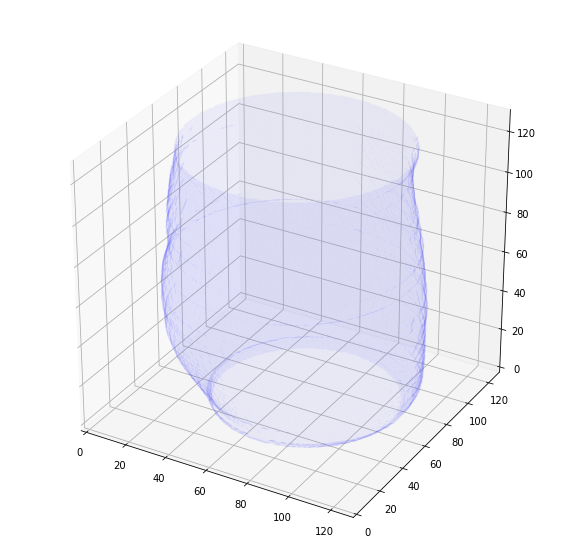

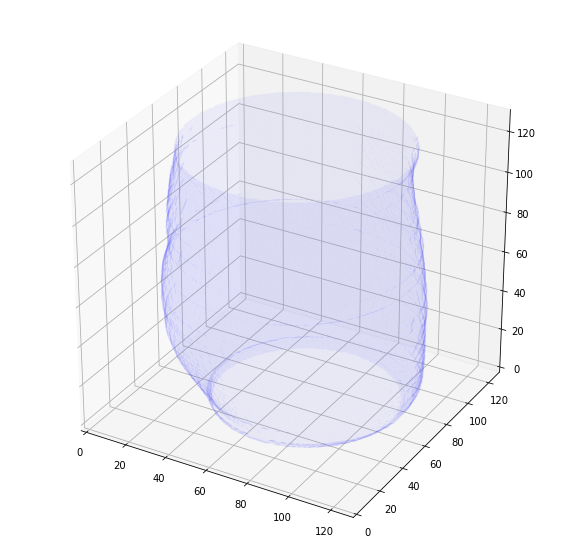

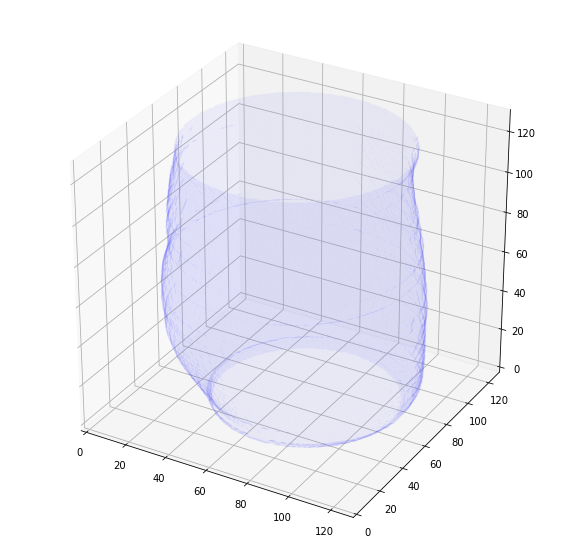

In [9]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology

def plot_3d(image): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
plot_3d(w.truth_circle)
plot_3d(w.double_circle)
plot_3d(w.single_circle)

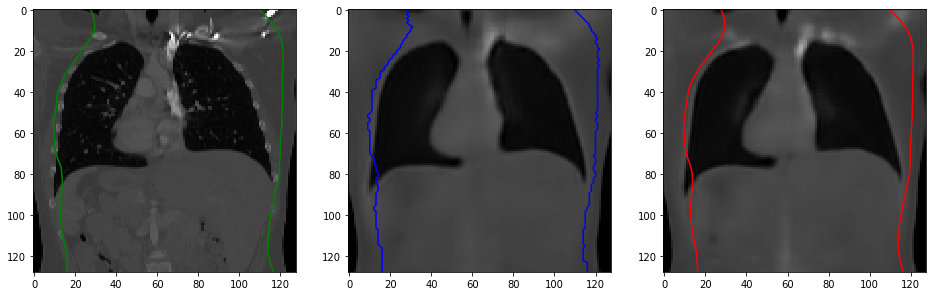

In [66]:
w.plot_all()

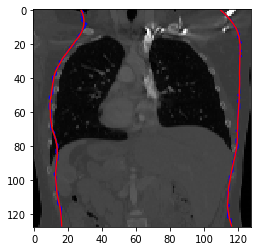

In [56]:
w.plotsingle()

In [ ]:
from copy import deepcopy

test_array = deepcopy(pd.y_train[13])
contour_scan = contour_image(test_array)

for i in range(0, 128):
    plt.imshow(contour_scan[i])
    plt.show()

In [55]:
print(w.truth_boundaries)
#print(w.truth_left_finals)
#print(w.truth_right_finals)

[(28, 110), (29, 111), (28, 112), (29, 113), (28, 114), (29, 115), (28, 116), (29, 117), (31, 117), (30, 118), (30, 118), (29, 119), (28, 120), (28, 120), (27, 121), (26, 120), (26, 120), (25, 121), (25, 121), (24, 122), (23, 121), (23, 121), (21, 121), (21, 121), (20, 122), (19, 121), (19, 121), (18, 122), (17, 121), (17, 121), (15, 121), (15, 121), (15, 121), (15, 121), (13, 121), (13, 121), (13, 121), (13, 121), (13, 121), (11, 121), (11, 121), (11, 121), (11, 121), (11, 121), (11, 121), (11, 121), (11, 121), (11, 121), (11, 121), (11, 121), (10, 120), (9, 121), (9, 121), (10, 120), (10, 120), (9, 121), (9, 121), (9, 121), (9, 121), (10, 120), (10, 120), (10, 120), (10, 120), (10, 120), (10, 120), (10, 120), (10, 120), (10, 120), (10, 120), (10, 120), (10, 120), (11, 119), (12, 120), (12, 120), (12, 120), (12, 120), (13, 119), (13, 119), (13, 119), (14, 120), (14, 120), (14, 120), (13, 119), (13, 119), (13, 119), (14, 118), (14, 118), (14, 118), (14, 118), (13, 117), (13, 117), (13,

In [13]:
print(w.truth_left_finals)
print("!!!!!!!!!!!!!!!!!!!!!!!!!m ")
print(w.truth_right_finals)

[28, 110, 29, 111, 28, 112, 29, 113, 28, 114, 29, 115, 28, 116, 29, 117, 31, 117, 30, 118, 30, 118, 29, 119, 28, 120, 28, 120, 27, 121, 26, 120, 26, 120, 25, 121, 25, 121, 24, 122, 23, 121, 23, 121, 21, 121, 21, 121, 20, 122, 19, 121, 19, 121, 18, 122, 17, 121, 17, 121, 15, 121, 15, 121, 15, 121, 15, 121, 13, 121, 13, 121, 13, 121, 13, 121, 13, 121, 11, 121, 11, 121, 11, 121, 11, 121, 11, 121, 11, 121, 11, 121, 11, 121, 11, 121, 11, 121, 11, 121, 10, 120, 9, 121, 9, 121, 10, 120, 10, 120, 9, 121, 9, 121, 9, 121, 9, 121, 10, 120, 10, 120, 10, 120, 10, 120, 10, 120, 10, 120, 10, 120, 10, 120, 10, 120, 10, 120, 10, 120, 10, 120, 11, 119, 12, 120, 12, 120, 12, 120, 12, 120, 13, 119, 13, 119, 13, 119, 14, 120, 14, 120, 14, 120, 13, 119, 13, 119, 13, 119, 14, 118, 14, 118, 14, 118, 14, 118, 13, 117, 13, 117, 13, 117, 13, 117, 13, 117, 13, 117, 13, 117, 12, 116, 12, 116, 13, 115, 13, 115, 13, 115, 13, 115, 13, 115, 13, 115, 13, 115, 13, 115, 13, 115, 14, 114, 14, 114, 14, 114, 14, 114, 14, 11

In [ ]:
from copy import deepcopy

test_array = deepcopy(pd.y_train[13])
contour_scan = contour_image(test_array)

for i in range(0, 128):
    plt.imshow(contour_scan[i])
    plt.show()

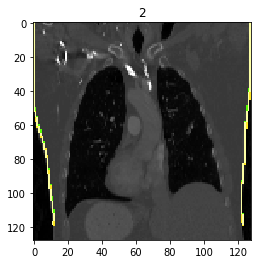

In [7]:
def get_blank_array(contour_scan):
    
    left, right = get_boundaries(contour_scan)
    left_list = []
    right_list = []
    
    for i in range(0, len(left)):
        norm_tup = (left[i][0], left[i][1], i)
        left_list.append(norm_tup)
    
    for i in range(0, len(right)):

        norm_tup = (right[i][0], right[i][1], i)
        right_list.append(norm_tup)
        
    blank_array = np.zeros((128, 128))

    for i in left_list:
        blank_array[i[2], i[1]] = 1

    for i in right_list:
        blank_array[i[2], i[1]] = 1
        
    return blank_array

def wed_plot_transverse(index):
    
    input_1 = pd.x_train_0[index]
    input_2 = pd.x_train_1[index]
    
    input_1 = np.reshape(input_1, (1, 1024, 1024, 1))
    input_2 = np.reshape(input_2, (1, 1024, 1024, 1))
    
    output_single = single_model.predict(input_1)
    output_double = double_model.predict([input_1, input_2])
    
    output_single = np.reshape(output_single, (128, 128, 128))
    output_double = np.reshape(output_double, (128, 128, 128))
    
    original = pd.y_train[index]
    
    org_copy = deepcopy(original)
    single_copy = deepcopy(output_single)
    double_copy = deepcopy(output_double)
    
    contour_org = contour_image(org_copy)
    contour_single = contour_image(single_copy)
    contour_double = contour_image(double_copy)
    
    bl_org = get_blank_array(contour_org)
    bl_single = get_blank_array(contour_single)
    bl_double = get_blank_array(contour_double)
    
    plt.imshow(pd.y_train[index][:, 64], cmap = 'gray')
    plt.imshow(ma.masked_values(bl_org, 0), cmap = 'prism_r')
    plt.imshow(ma.masked_values(bl_single, 0), cmap = 'viridis_r')
    plt.imshow(ma.masked_values(bl_double, 0), cmap = 'inferno_r')
    plt.title(str(index))
    plt.show()
    
wed_plot_transverse(2)

In [8]:
for i in range(0, 100):
    
    wed_plot_transverse(i)

KeyboardInterrupt: 

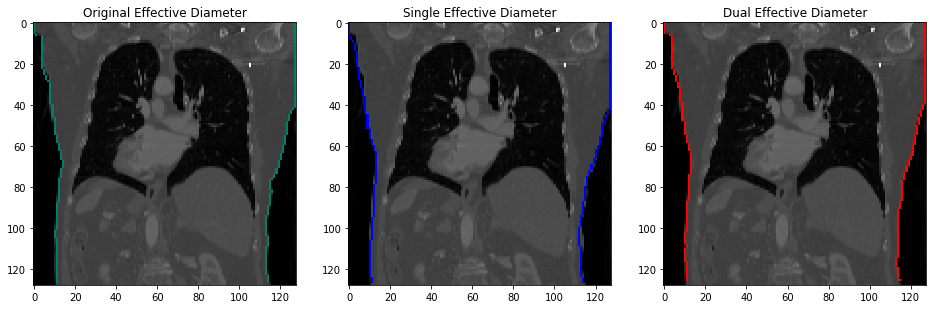

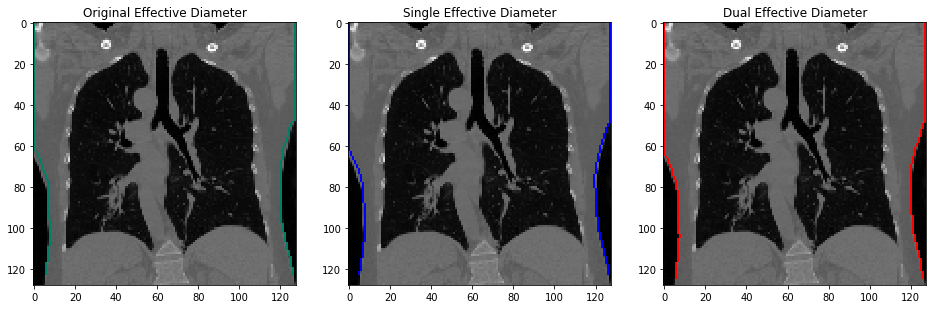

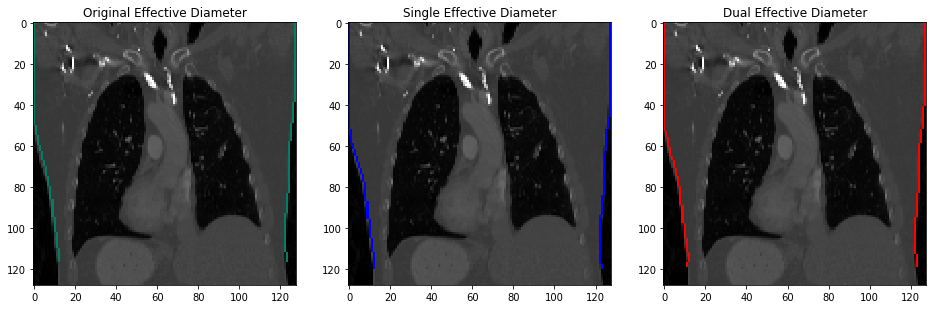

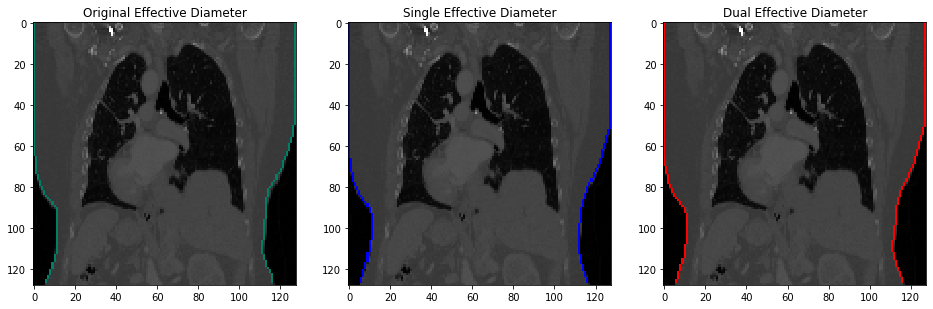

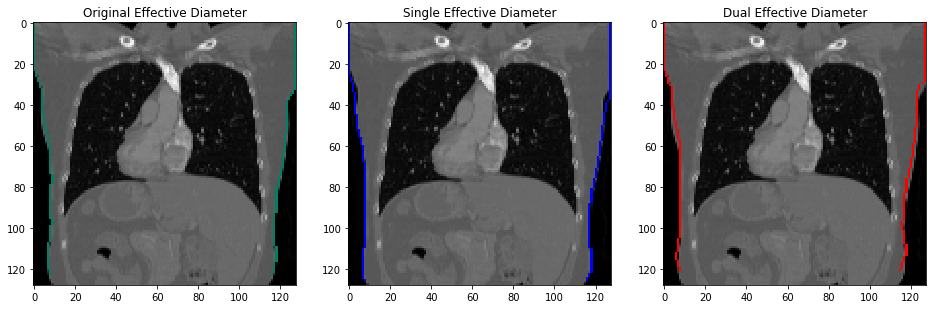

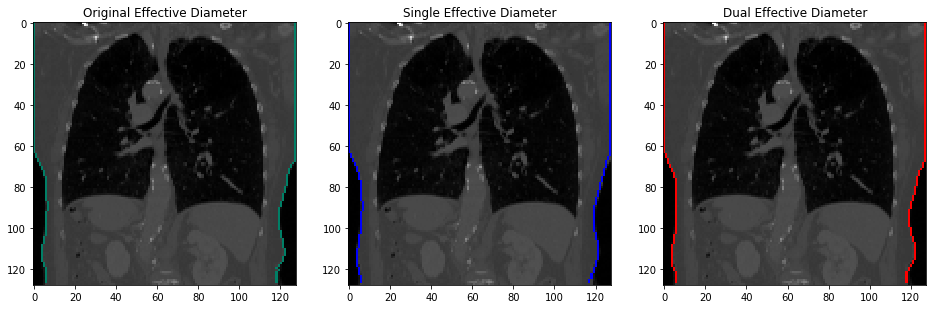

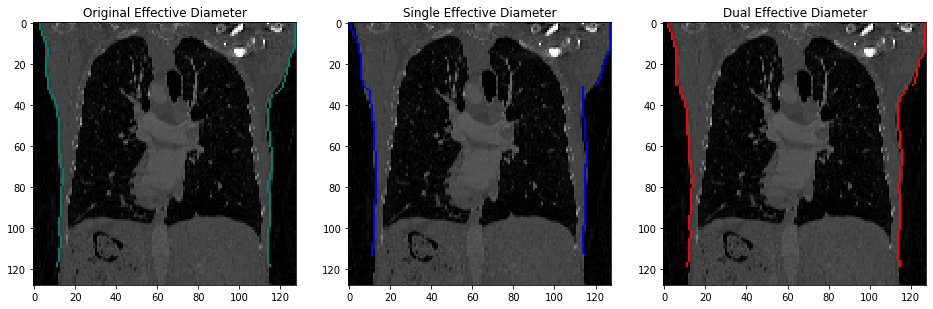

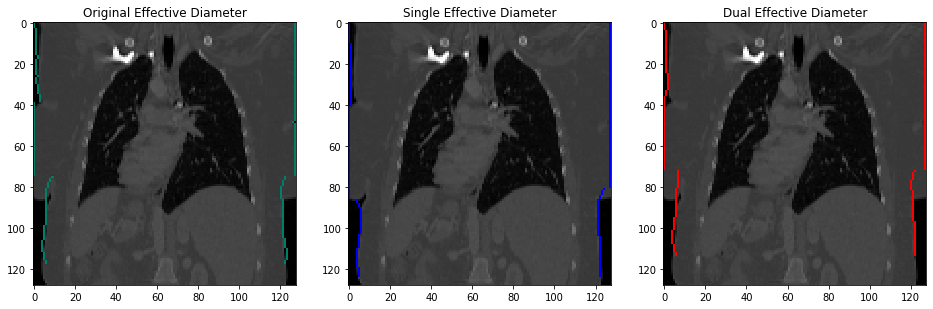

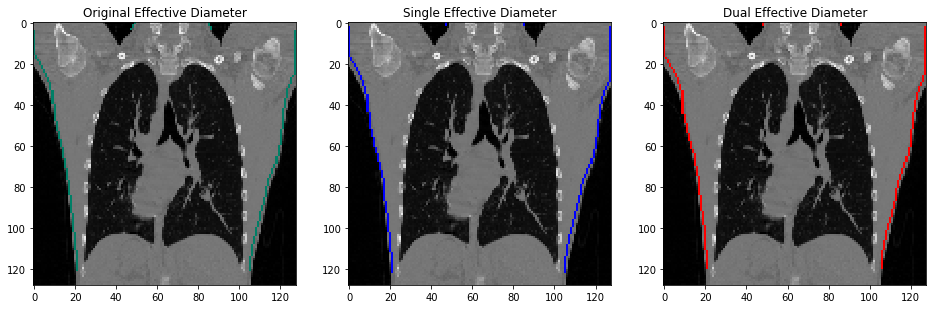

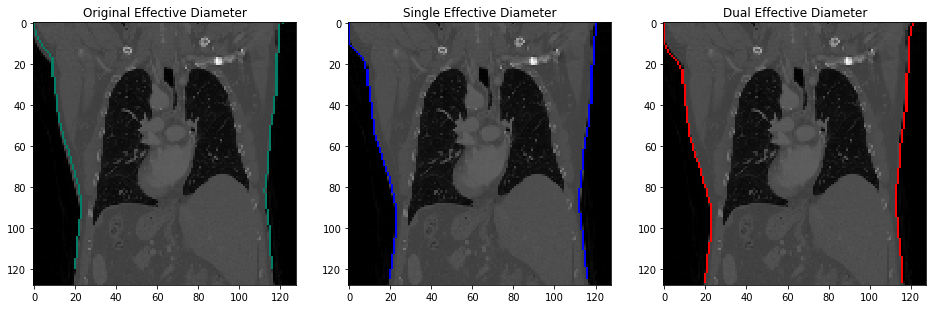

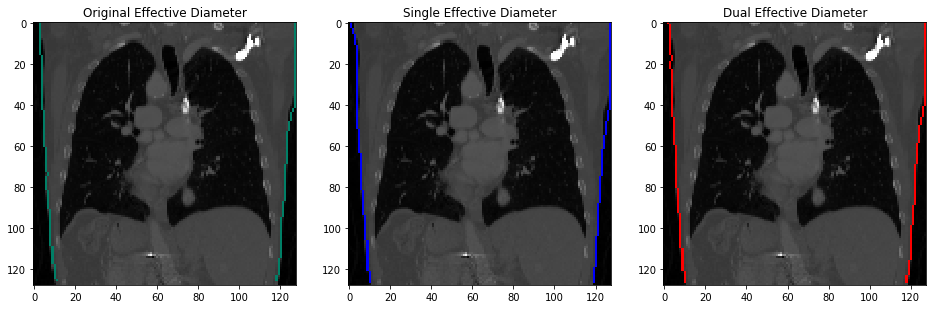

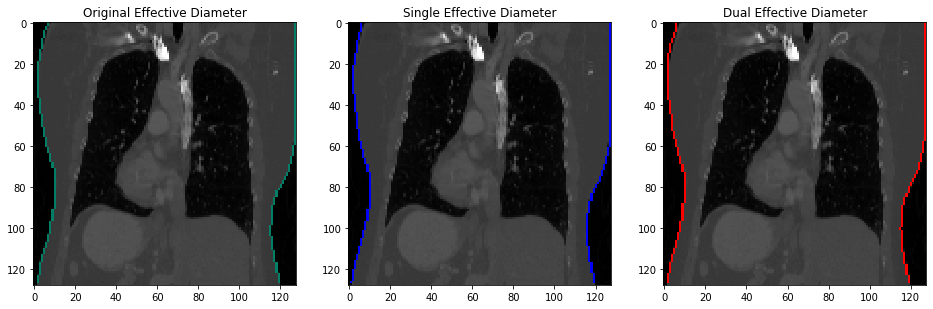

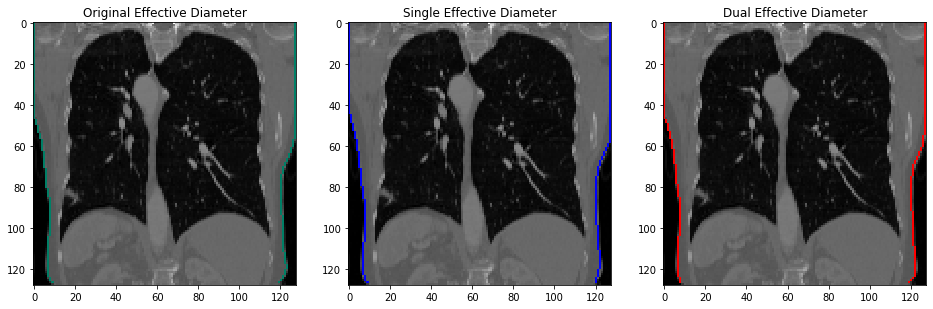

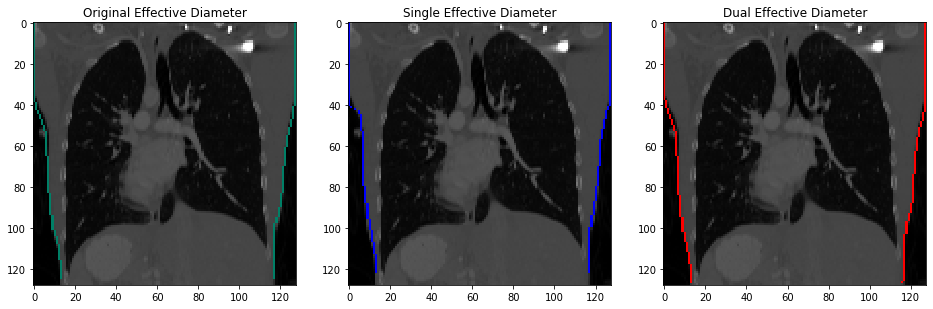

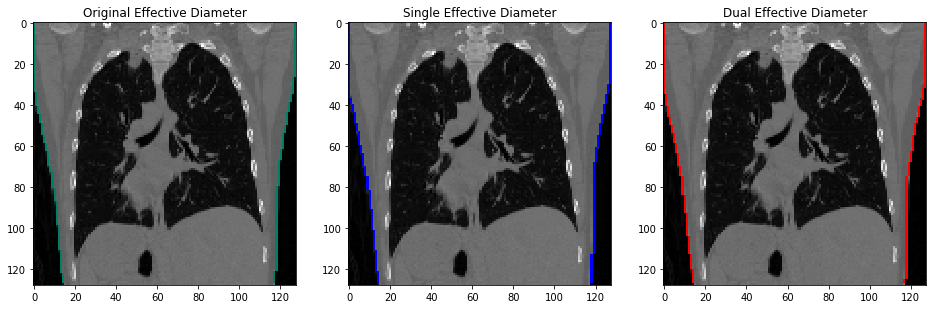

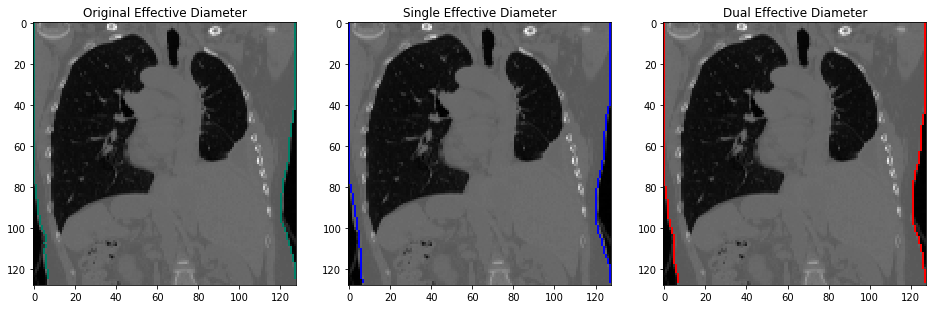

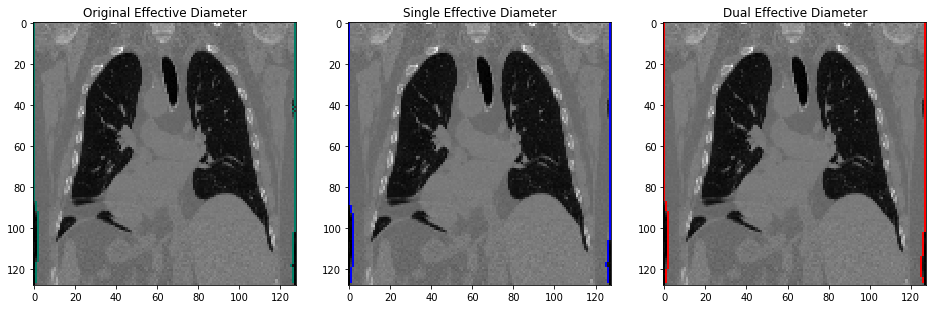

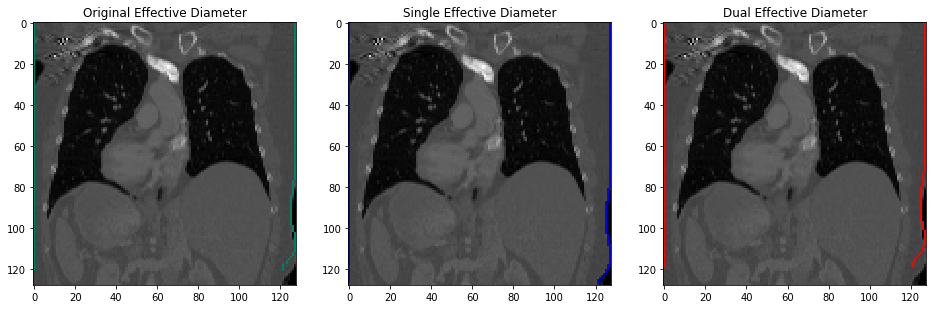

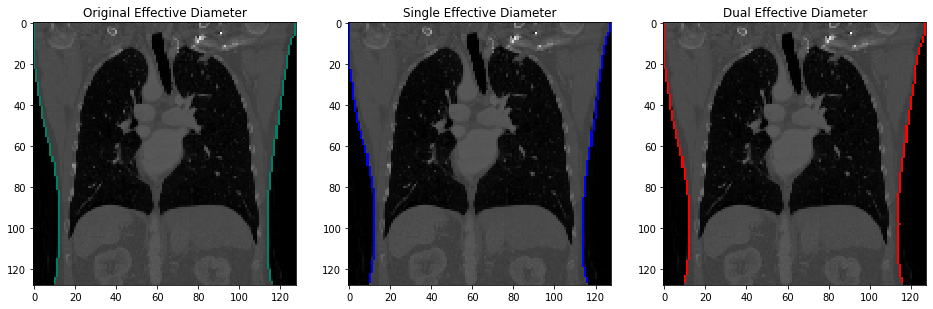

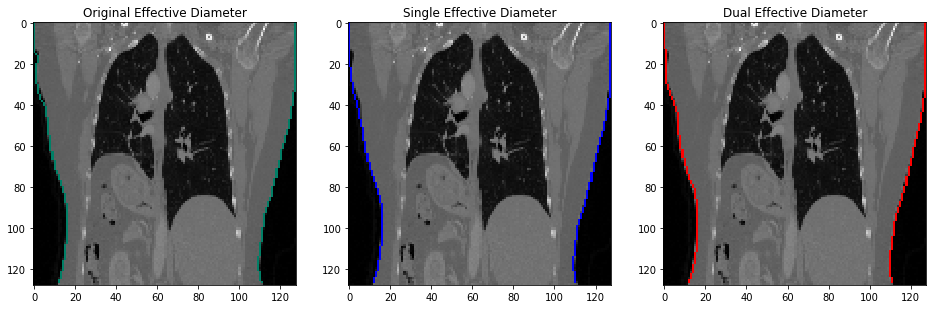

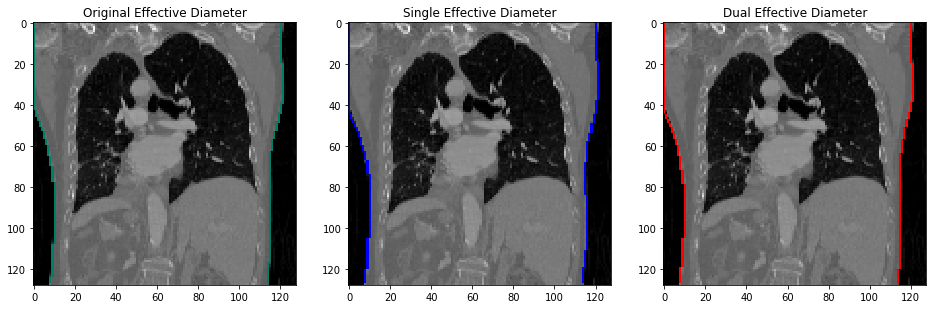

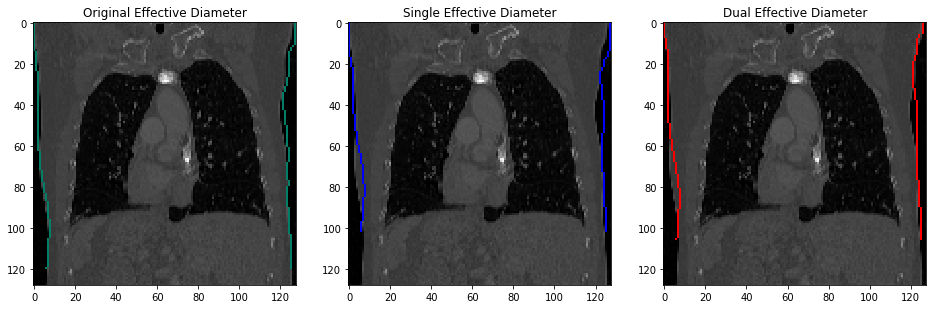

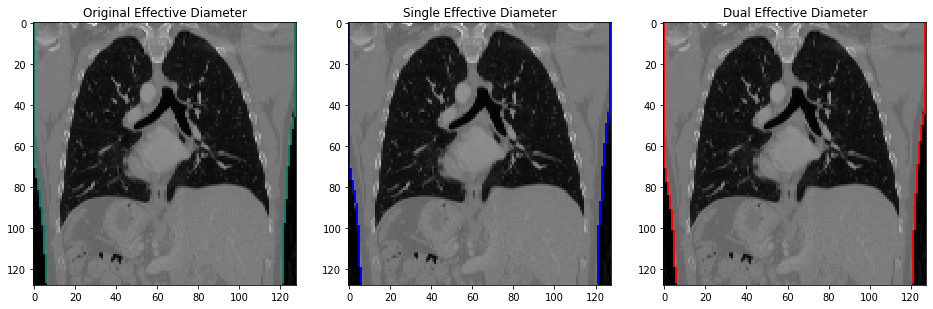

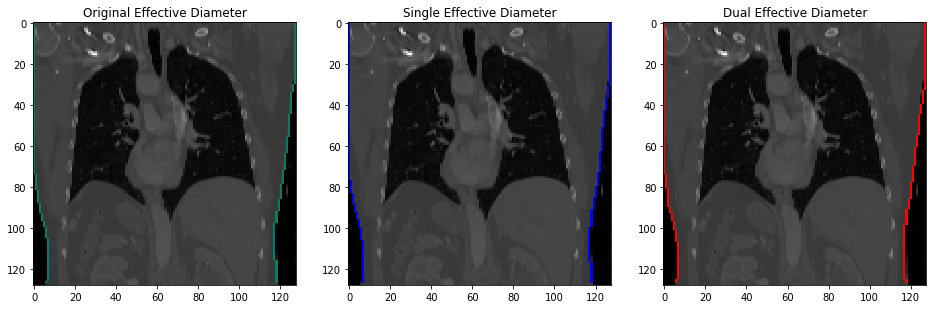

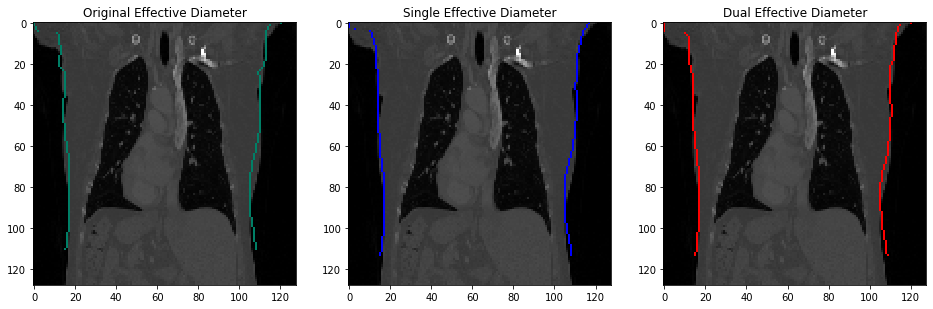

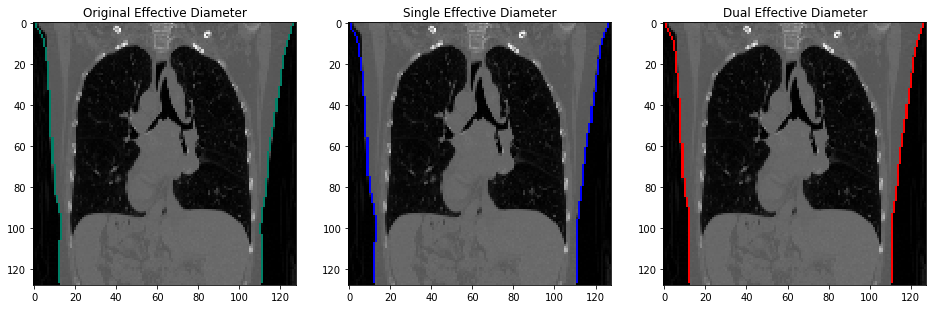

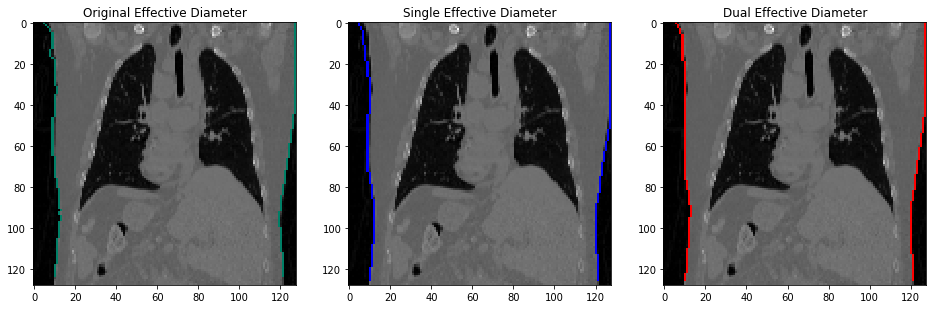

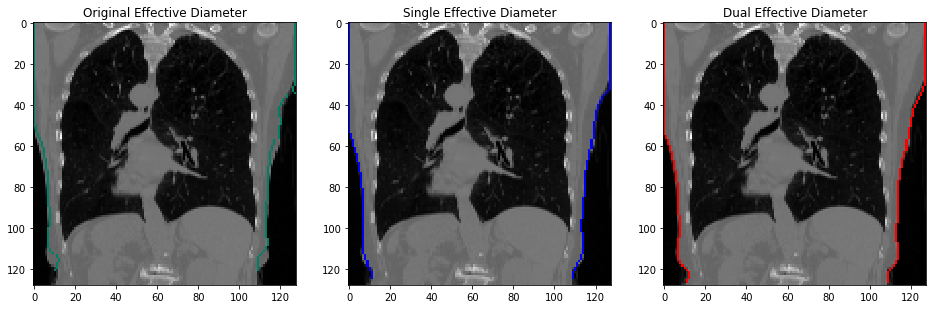

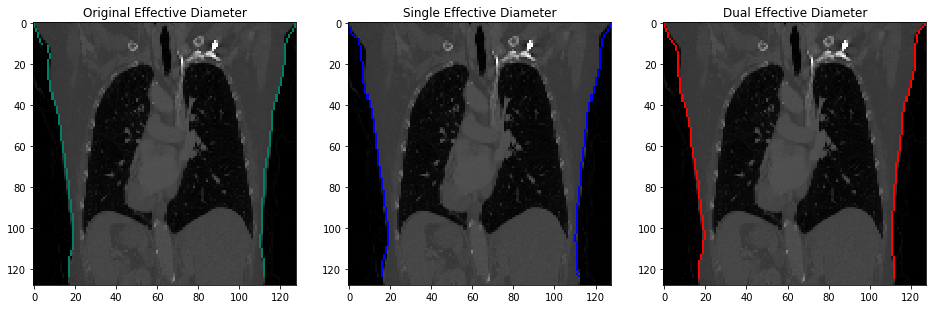

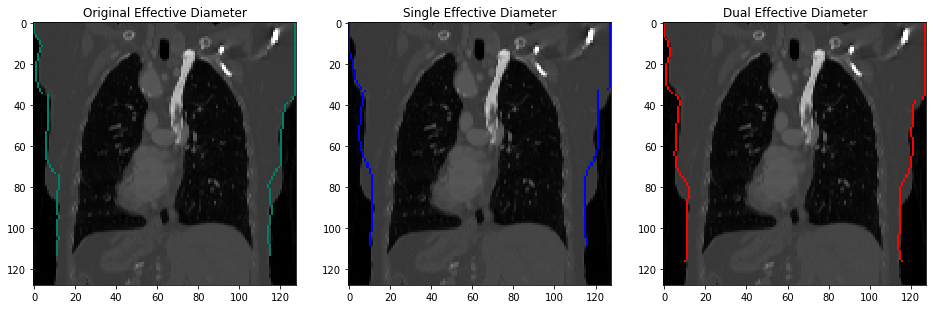

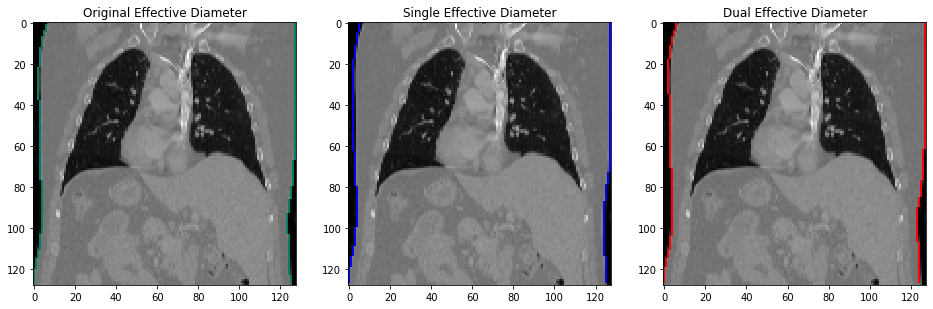

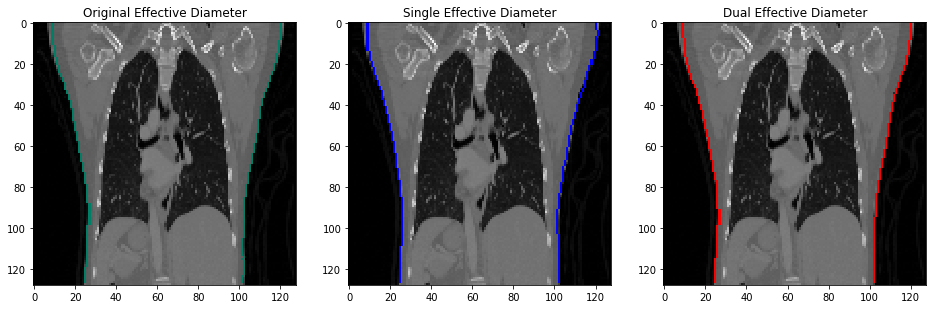

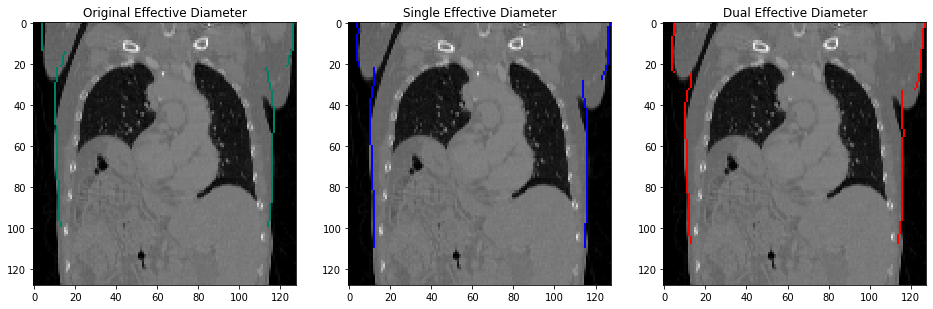

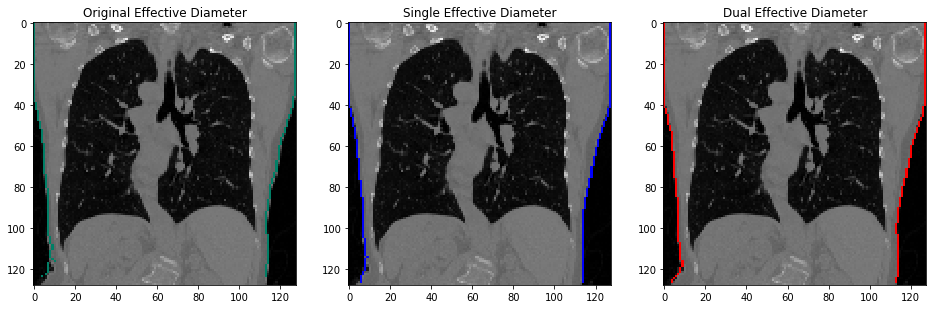

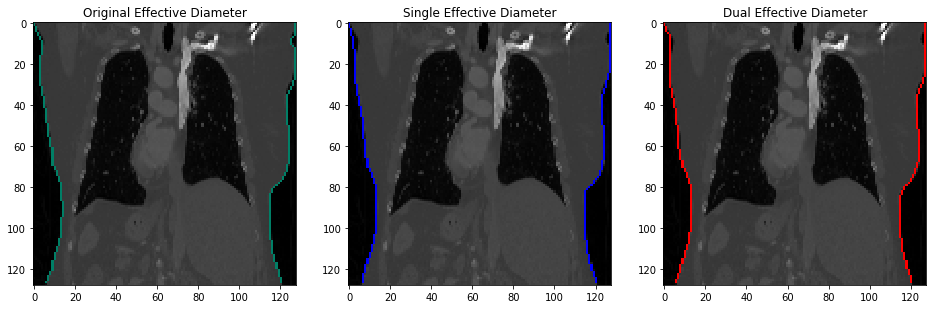

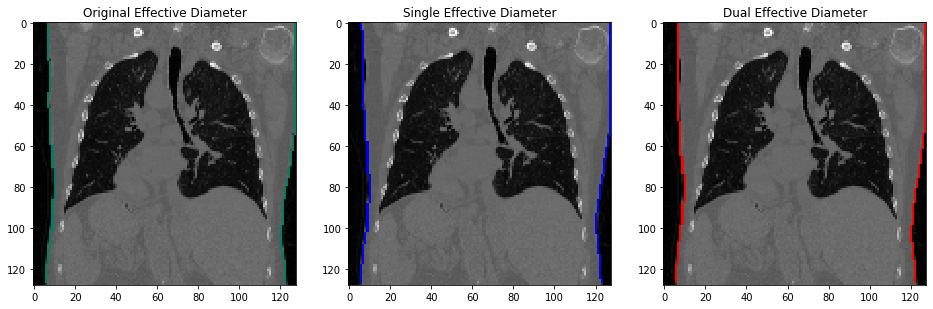

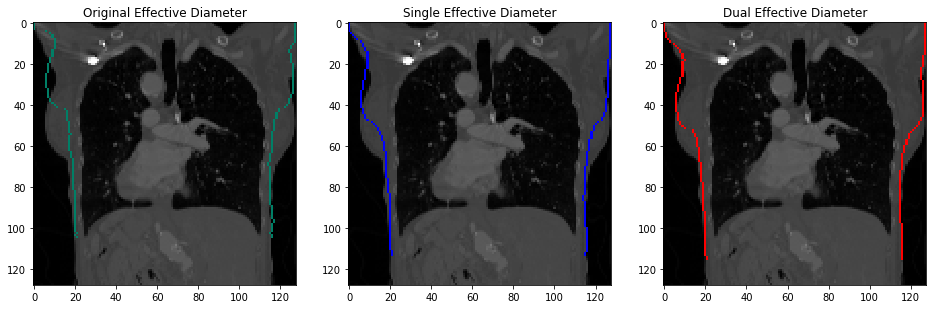

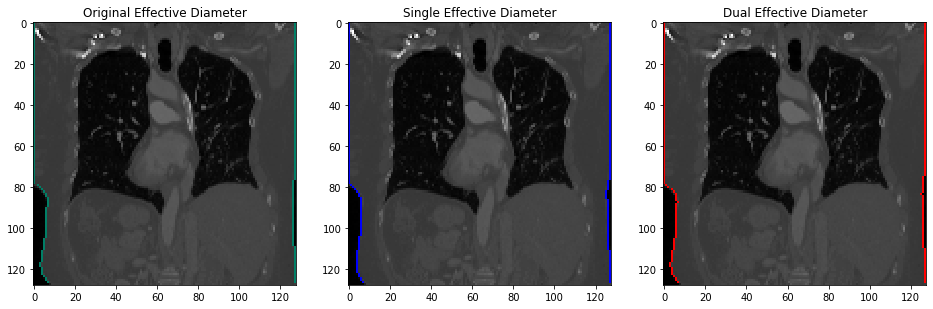

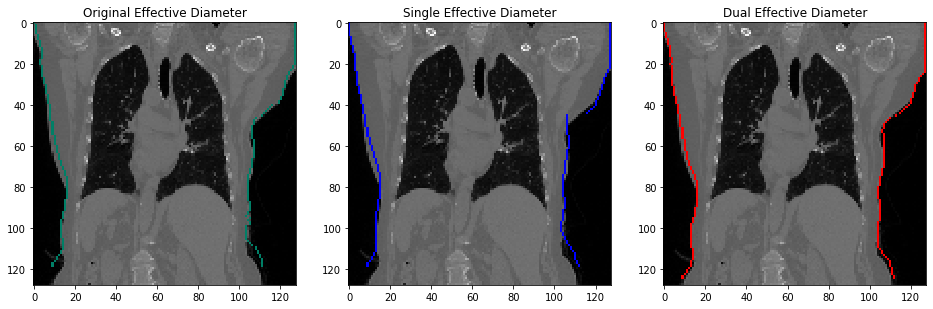

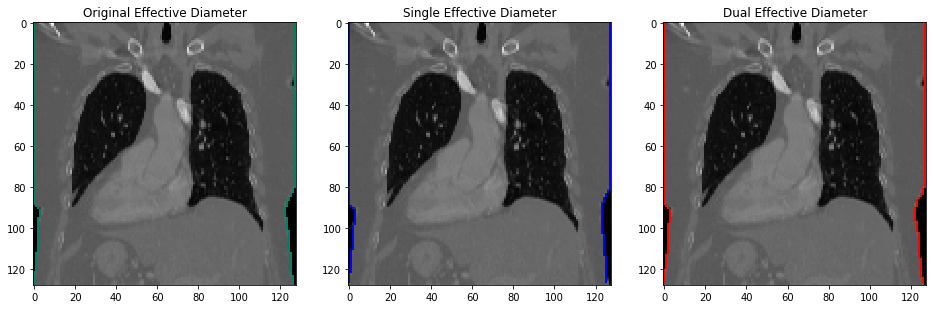

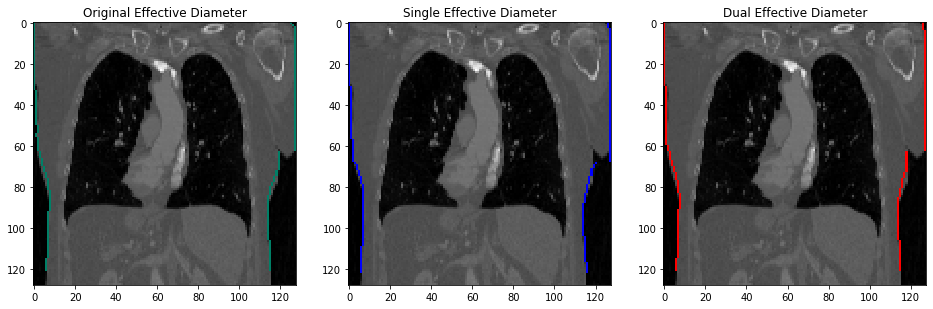

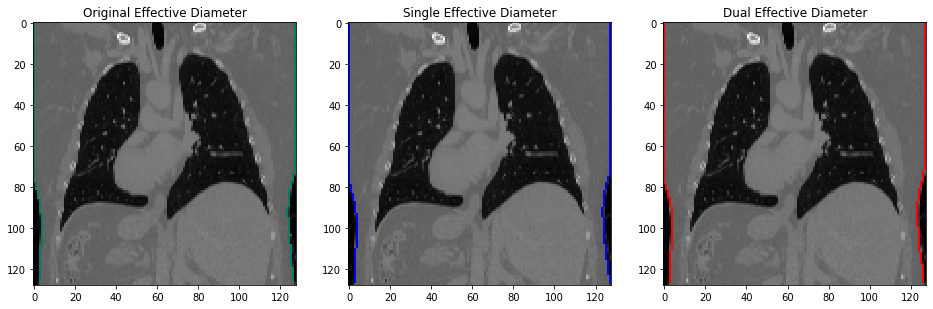

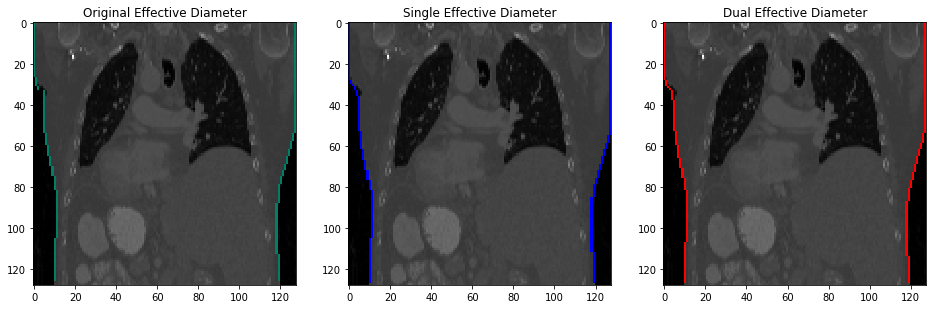

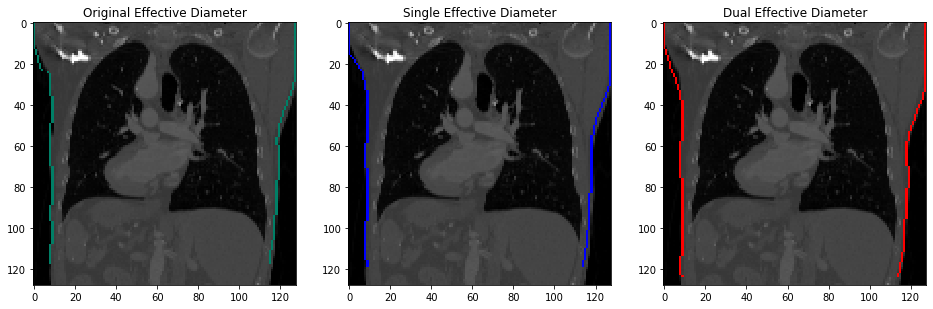

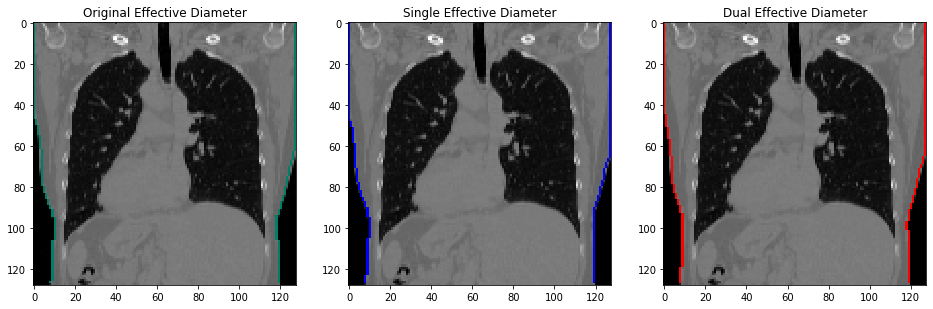

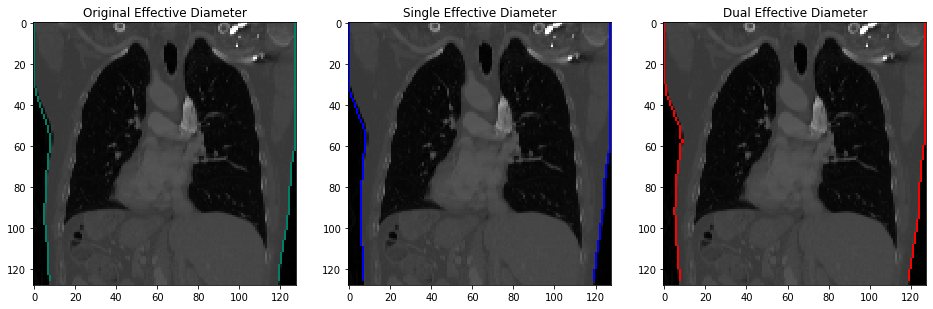

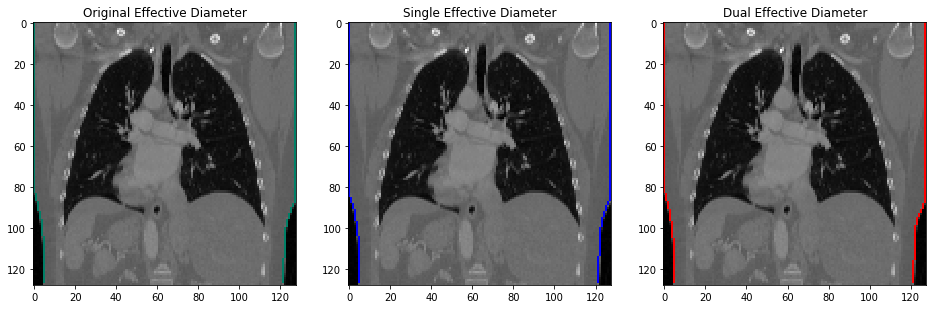

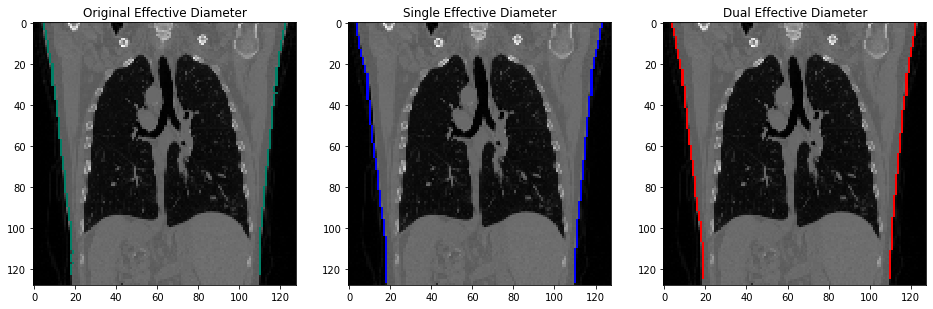

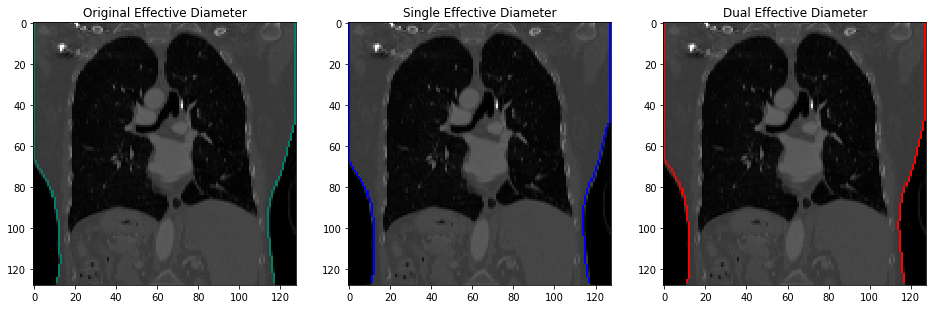

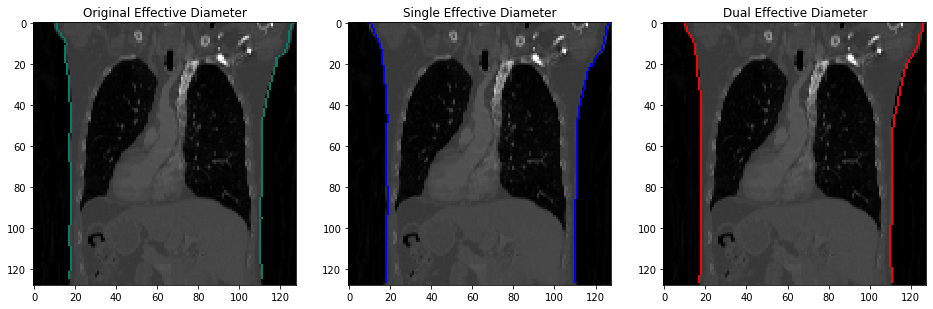

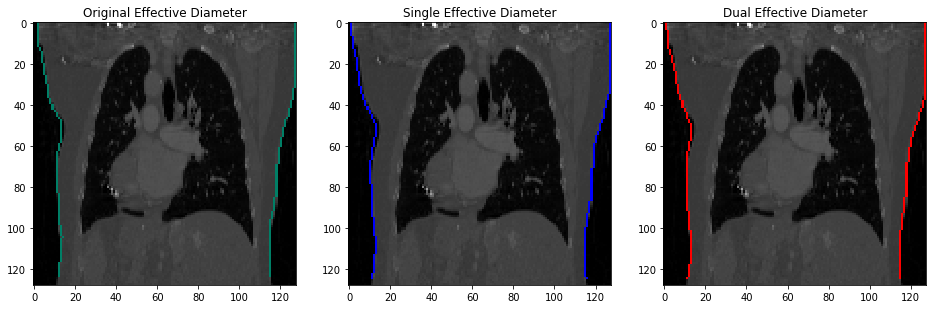

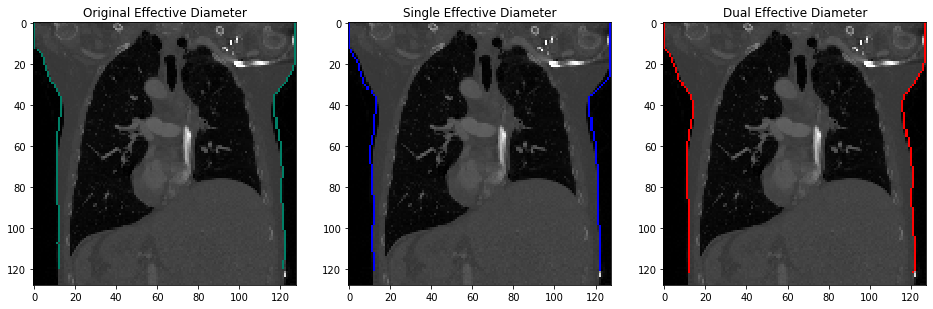

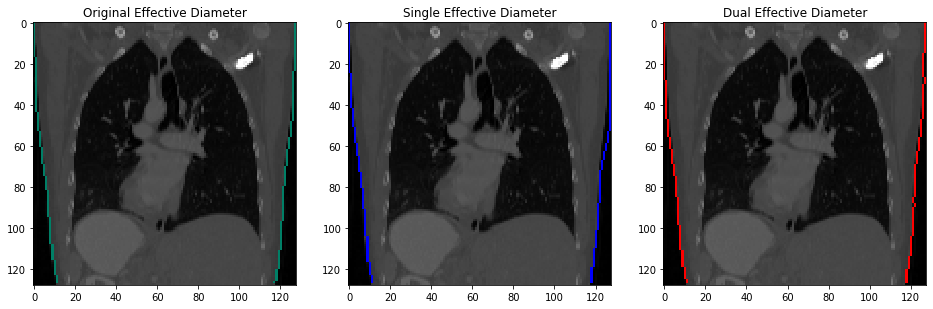

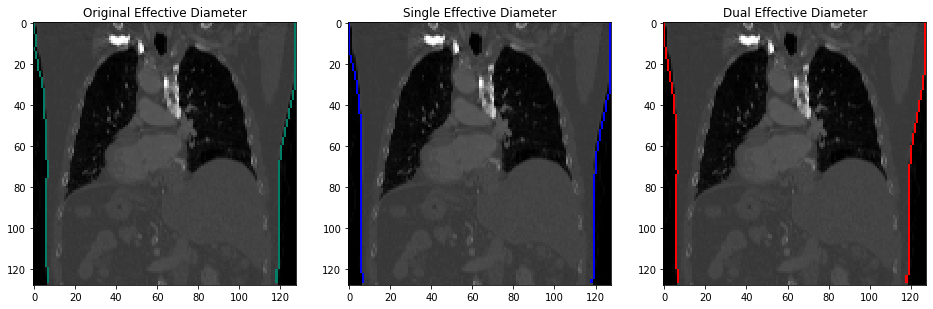

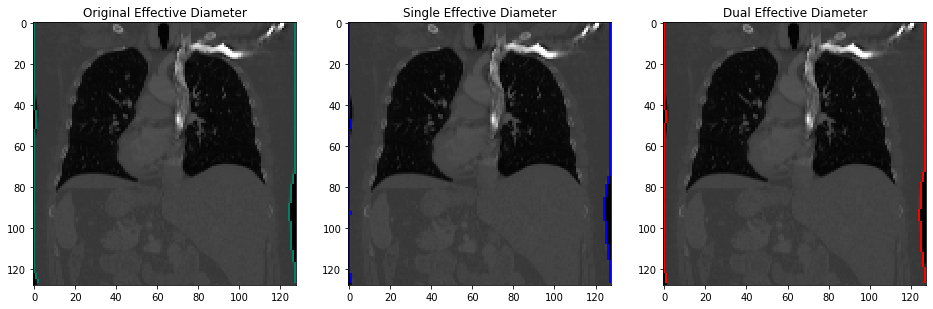

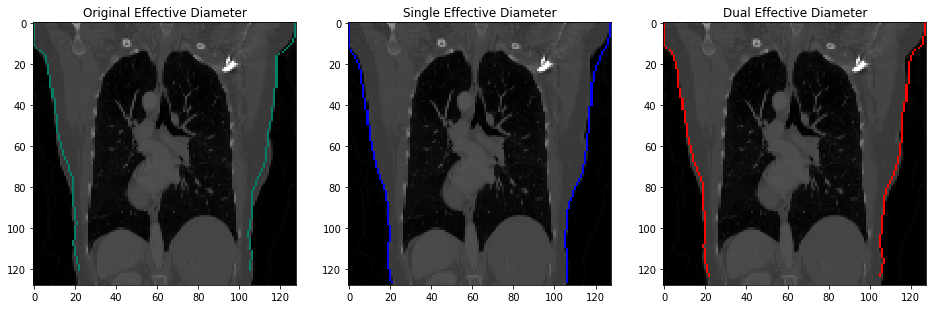

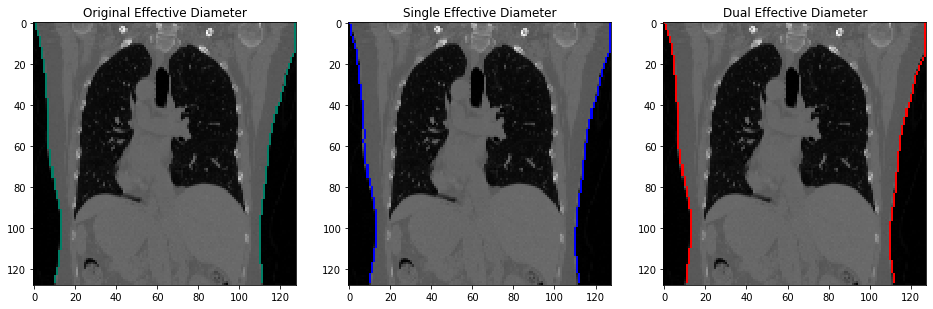

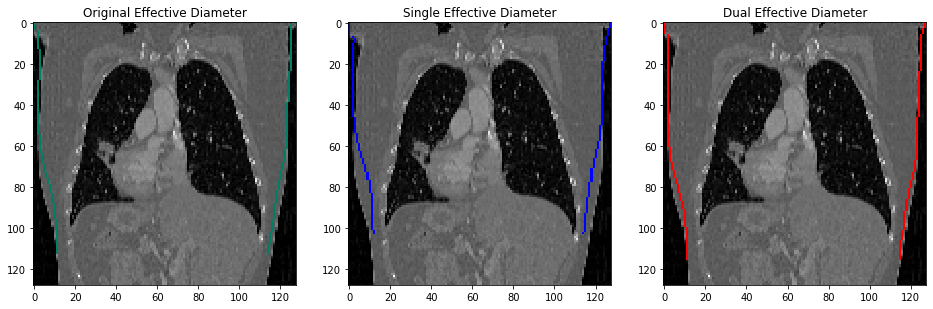

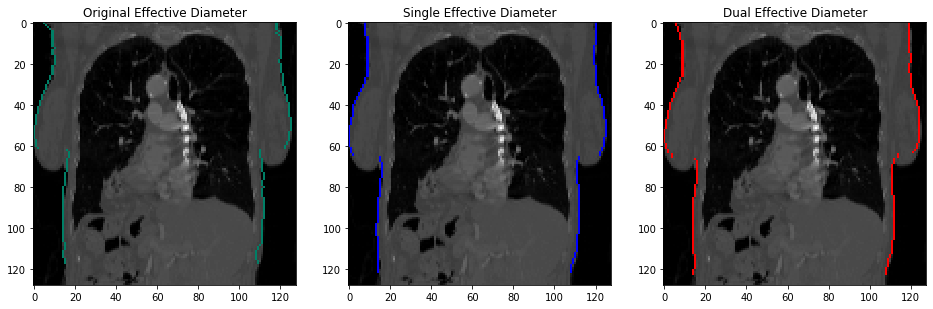

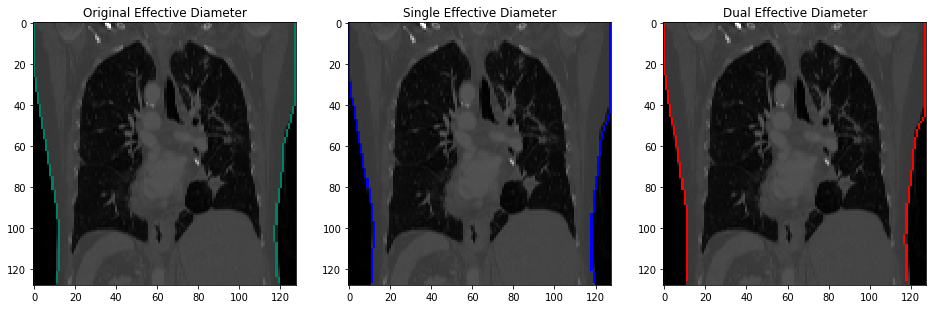

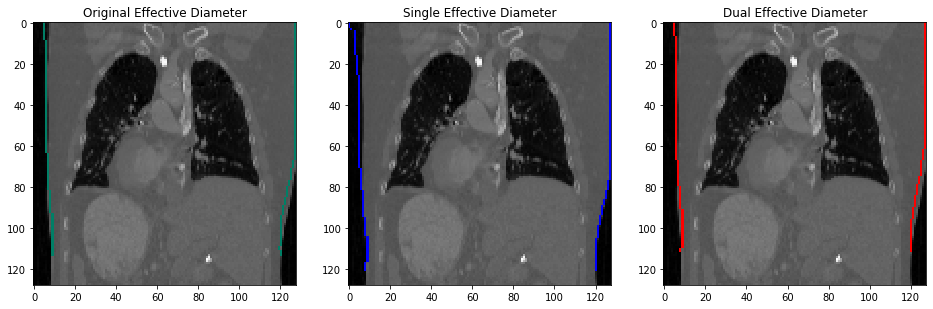

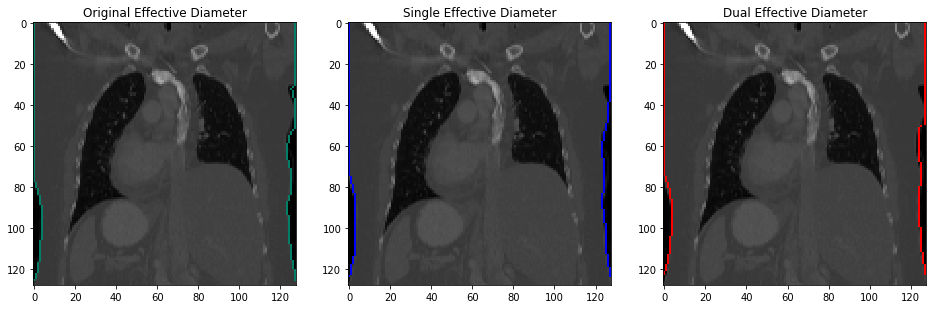

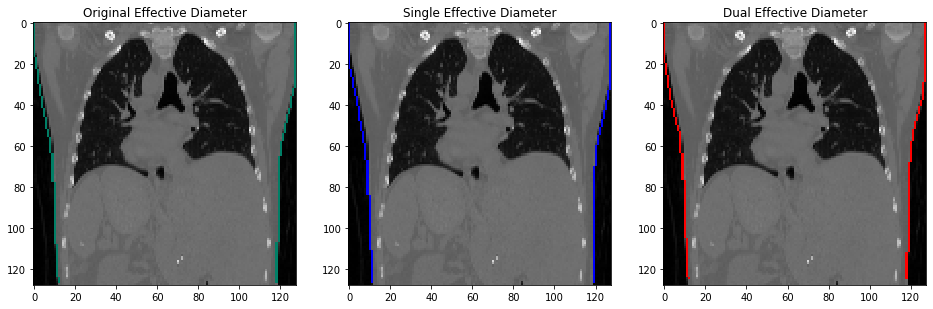

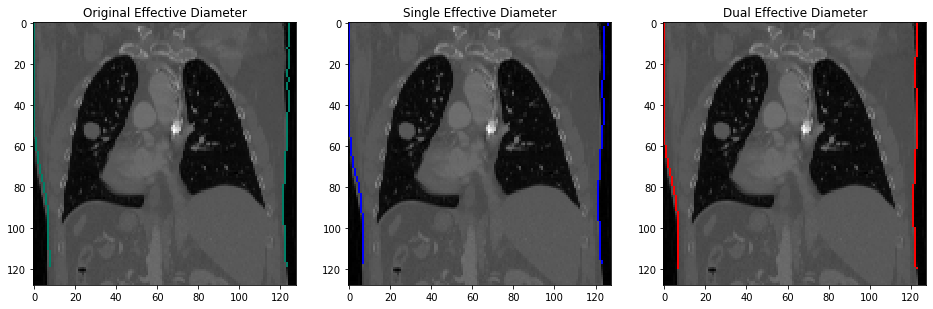

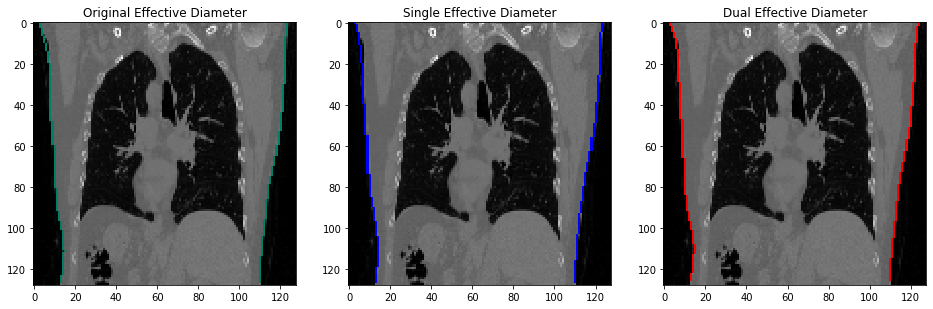

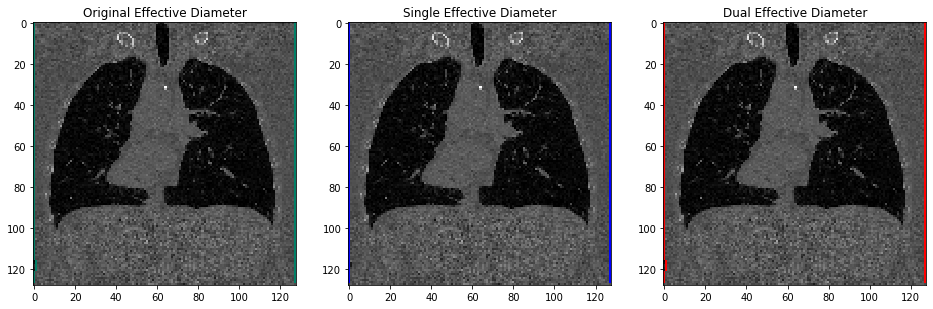

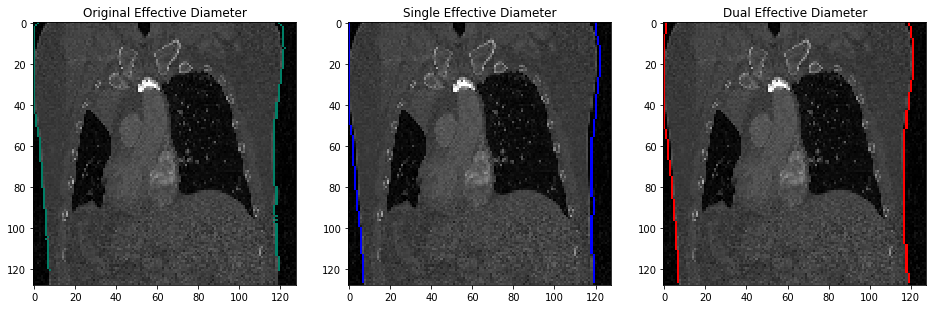

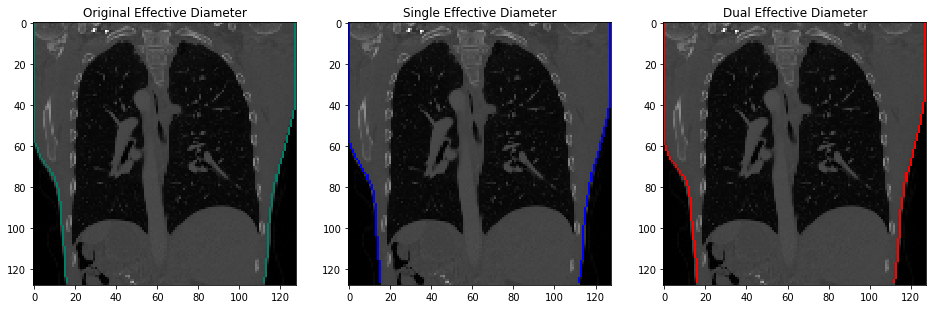

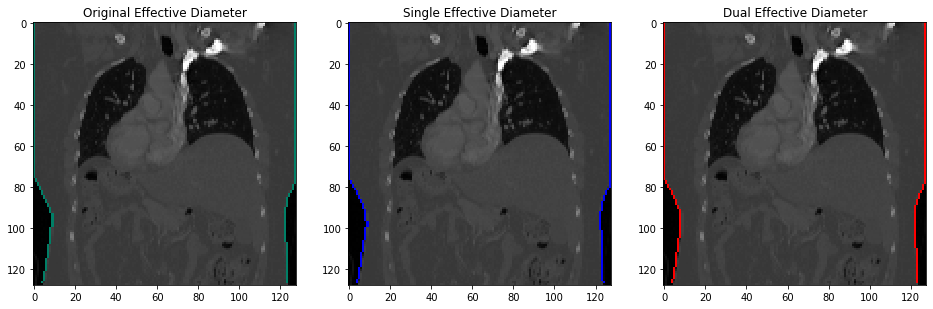

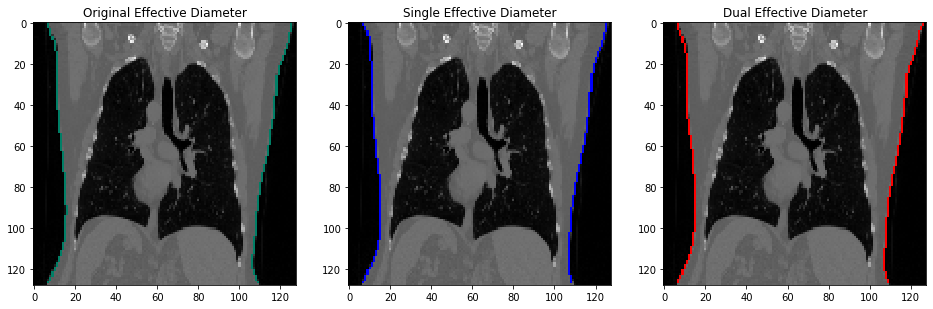

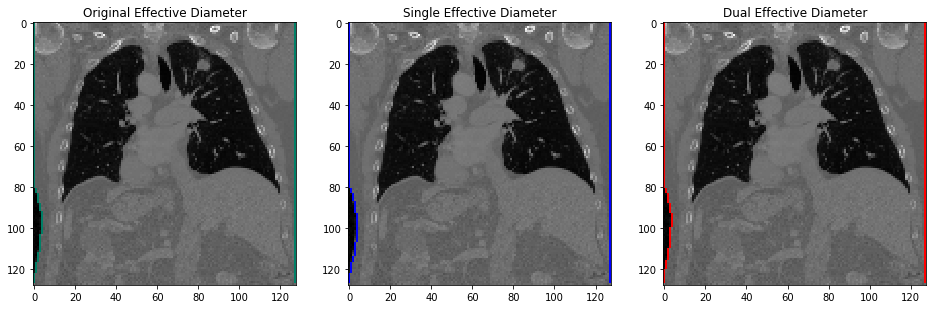

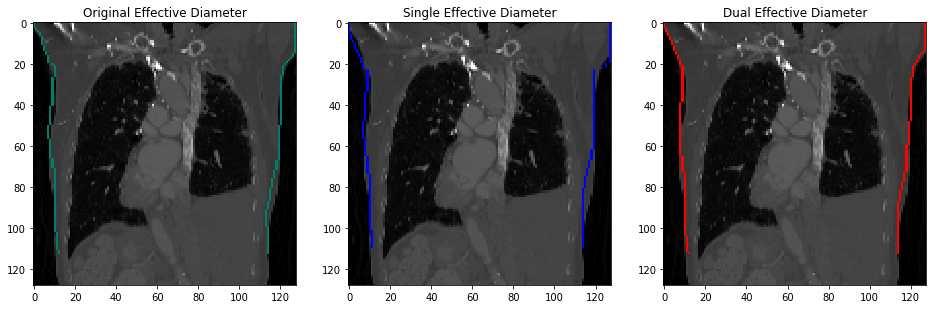

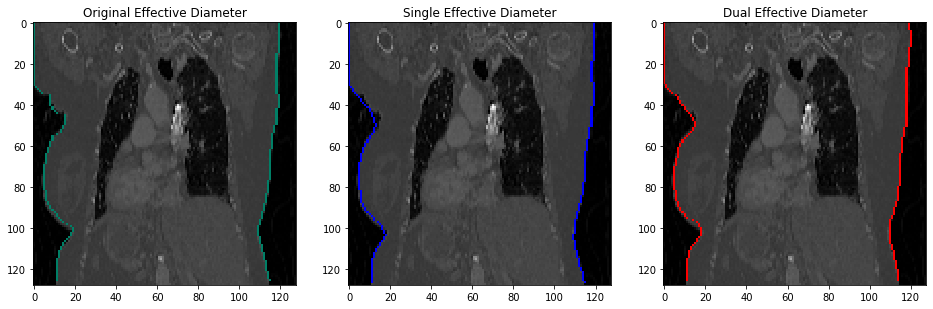

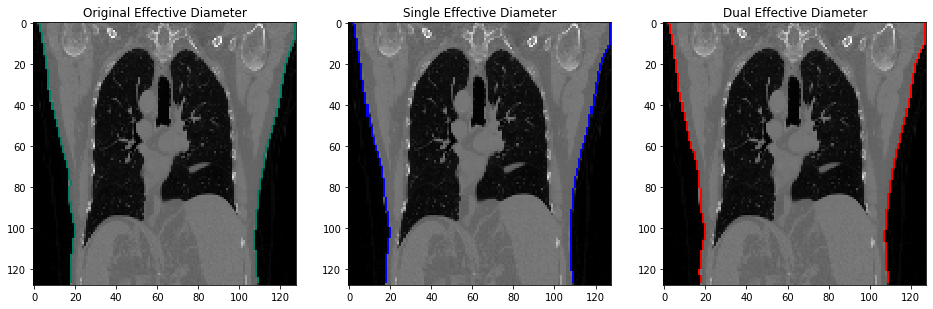

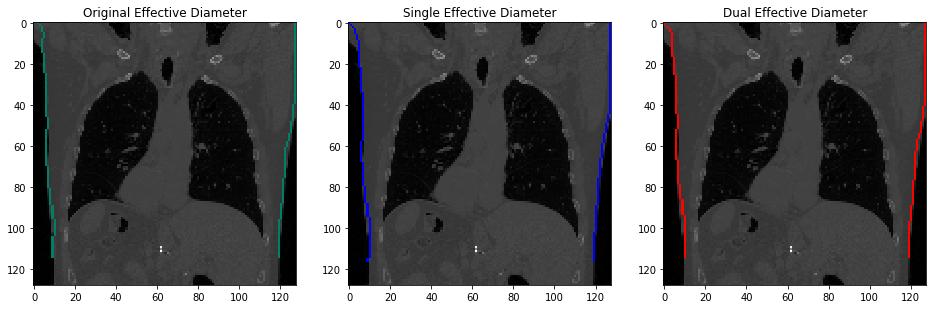

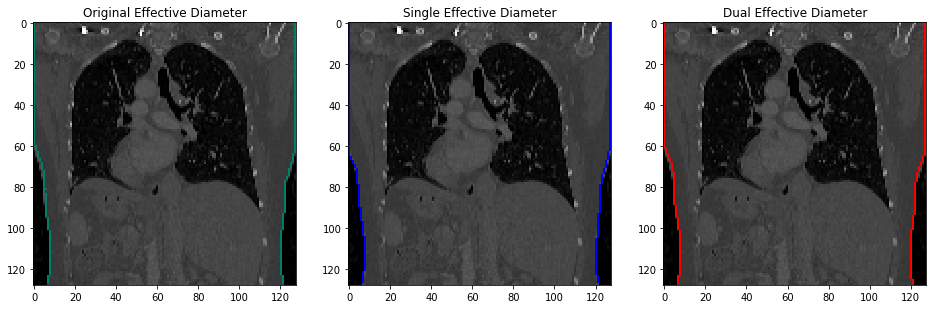

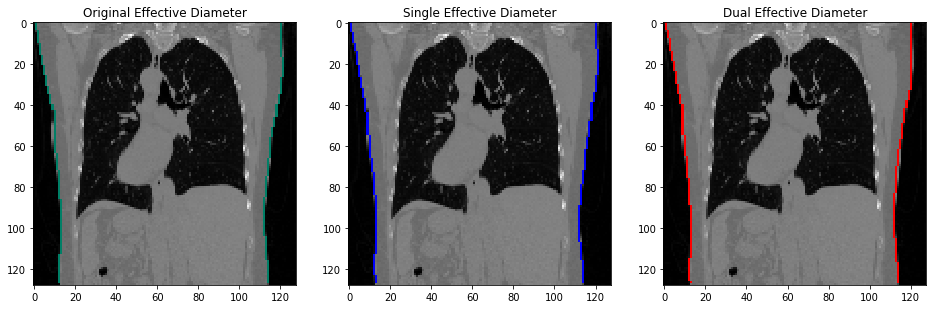

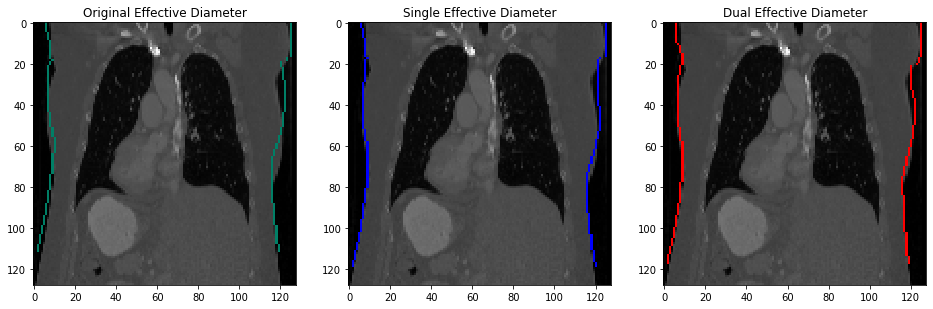

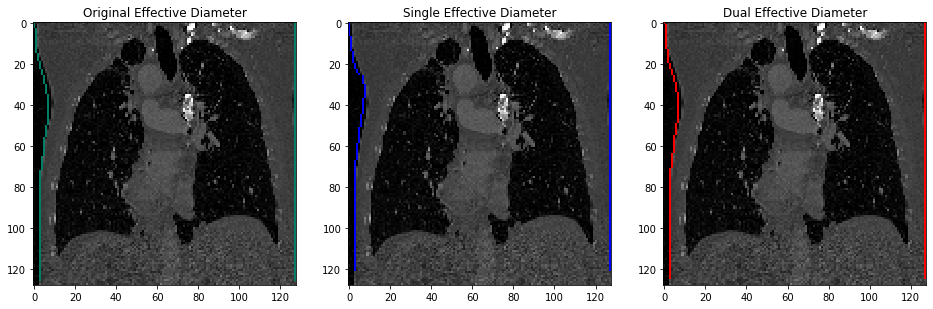

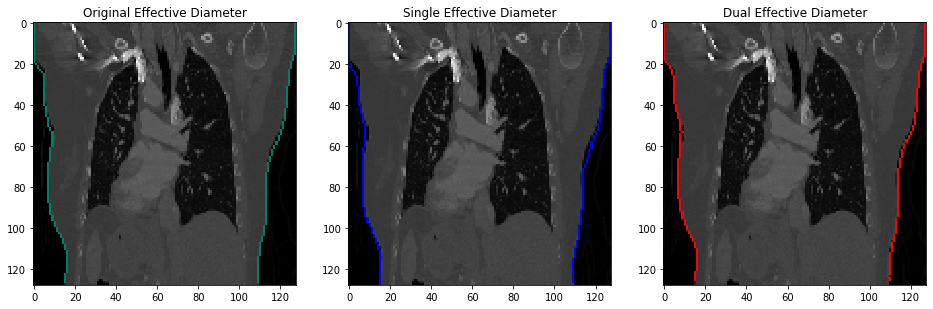

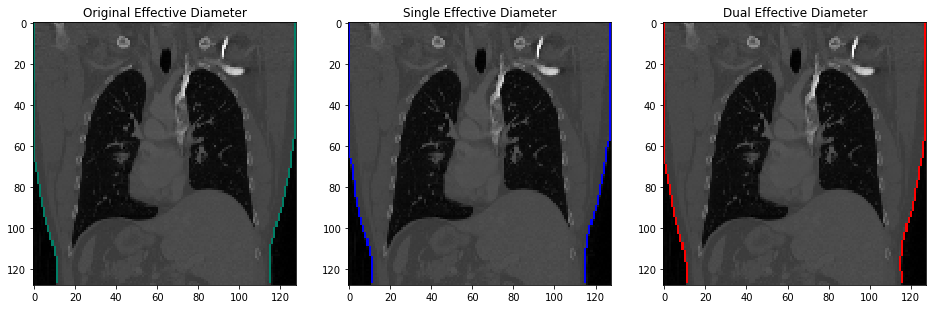

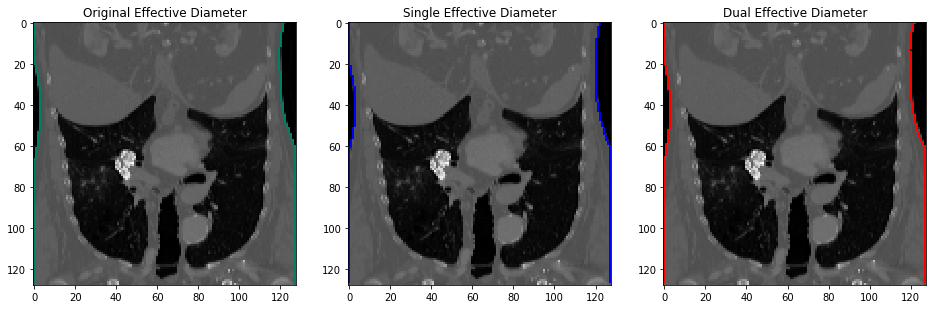

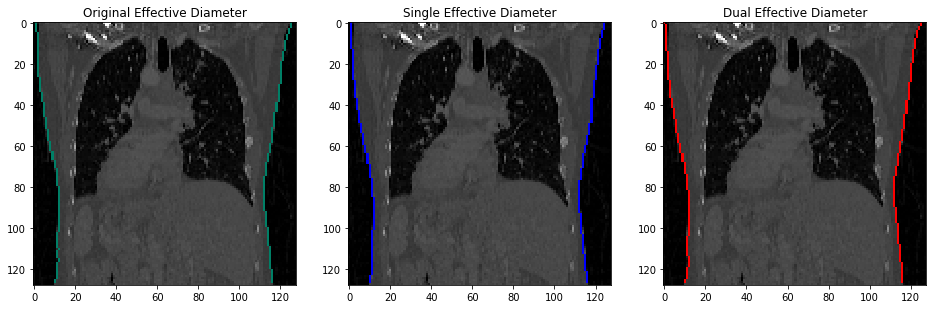

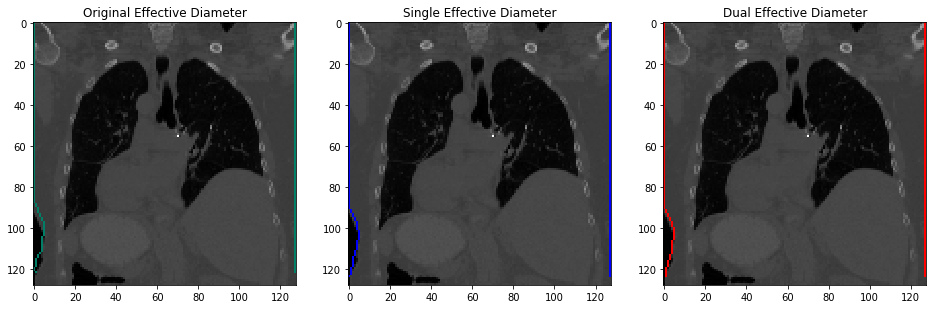

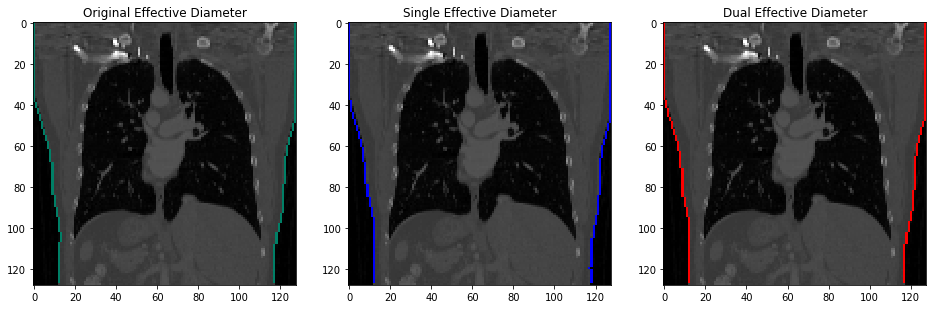

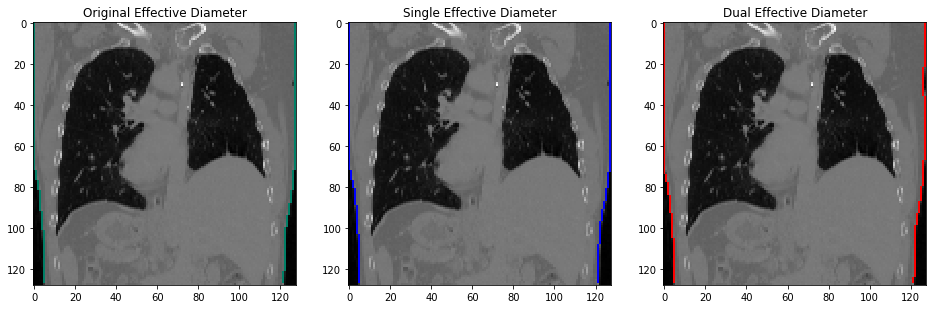

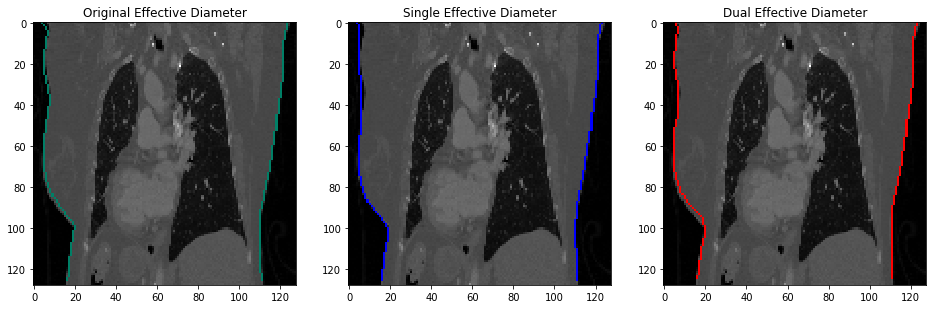

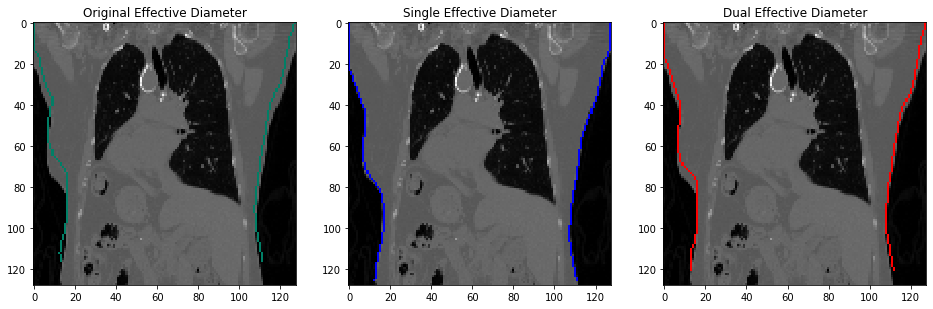

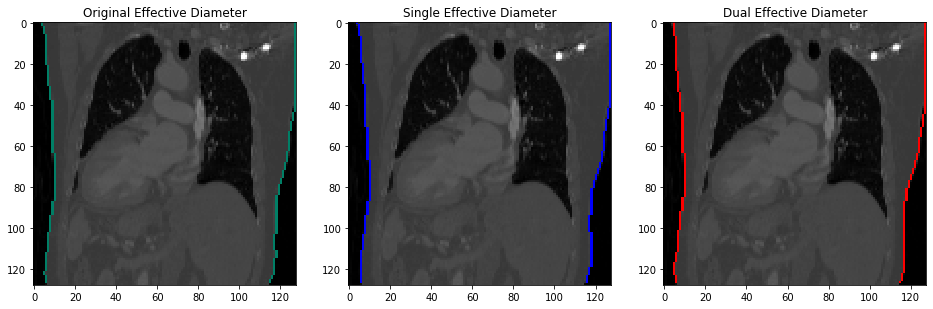

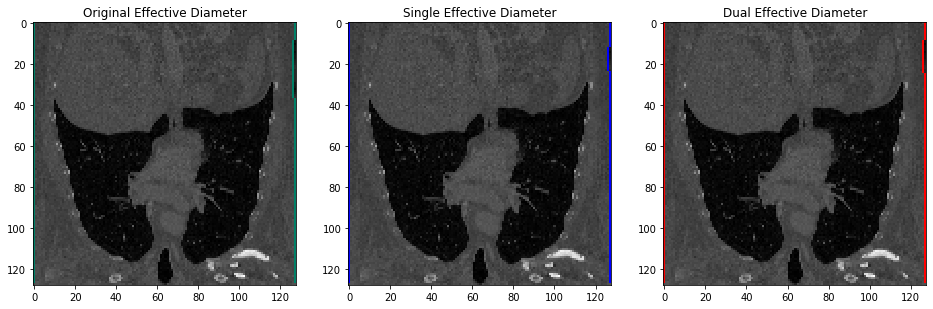

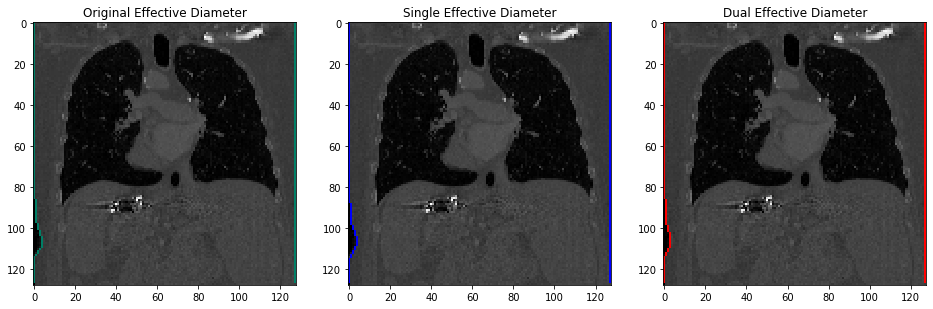

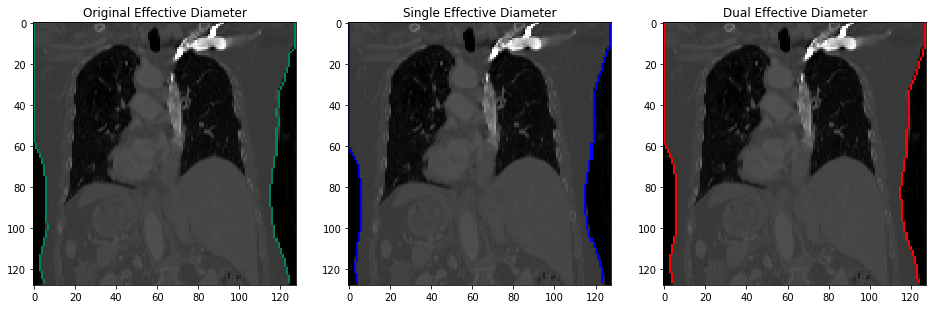

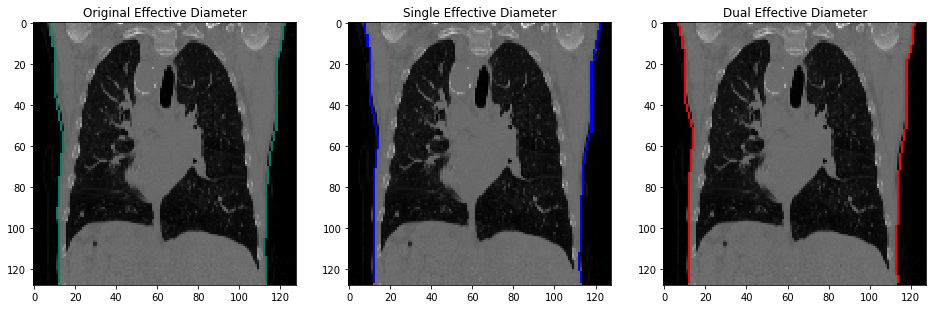

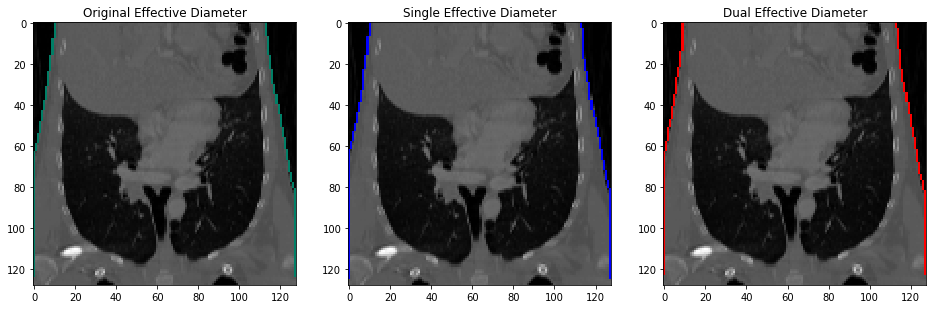

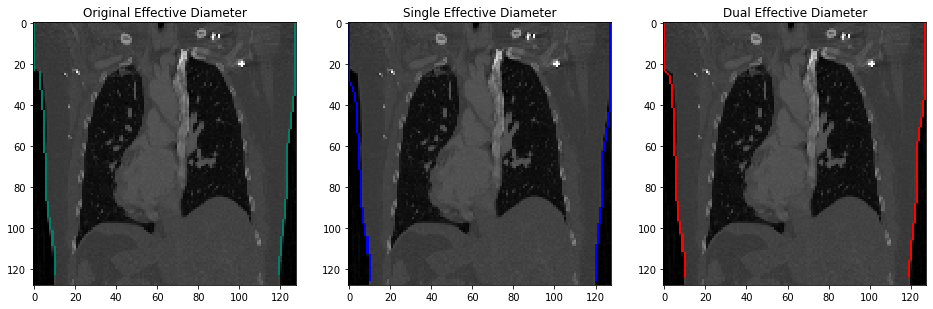

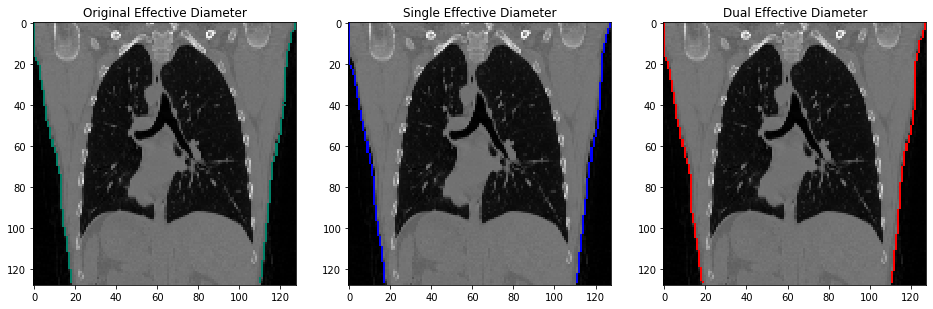

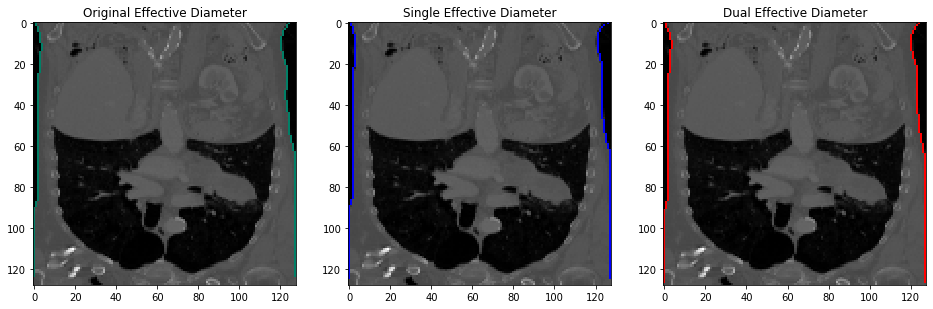

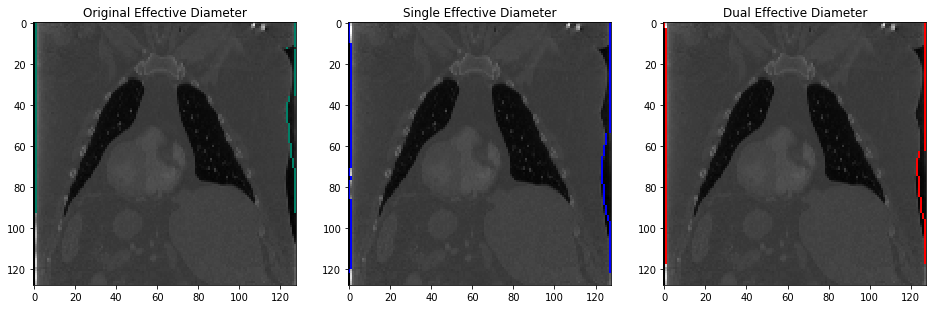

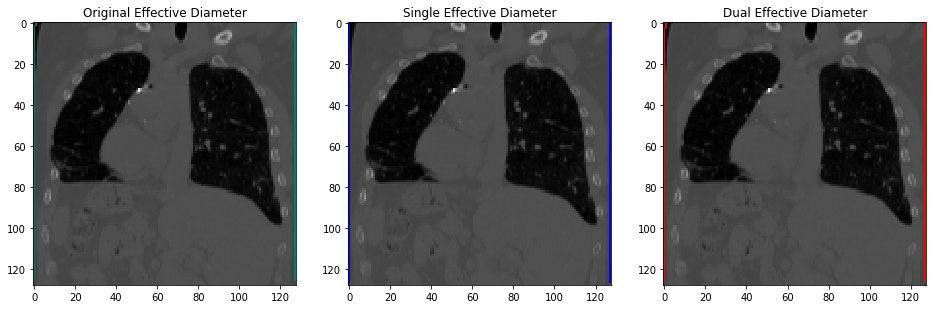

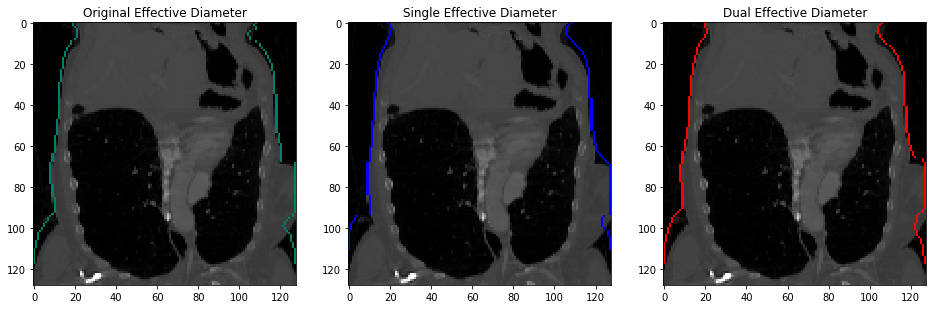

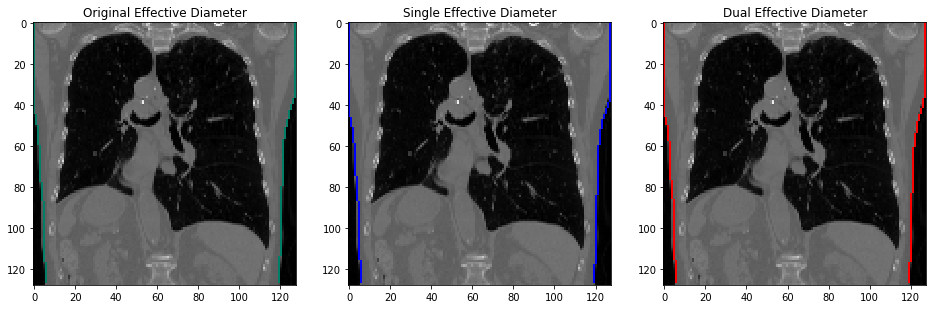

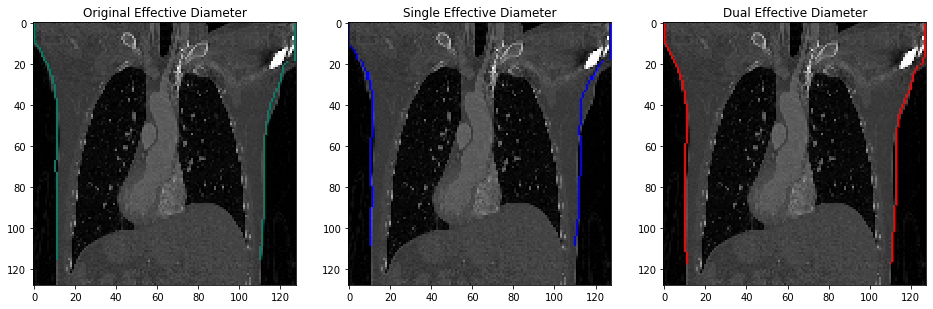

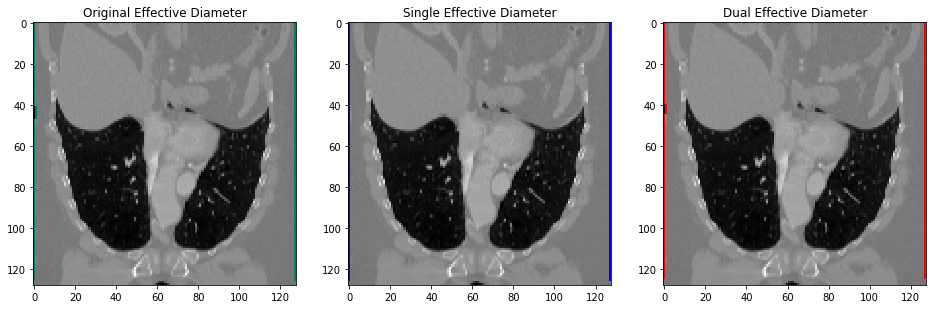

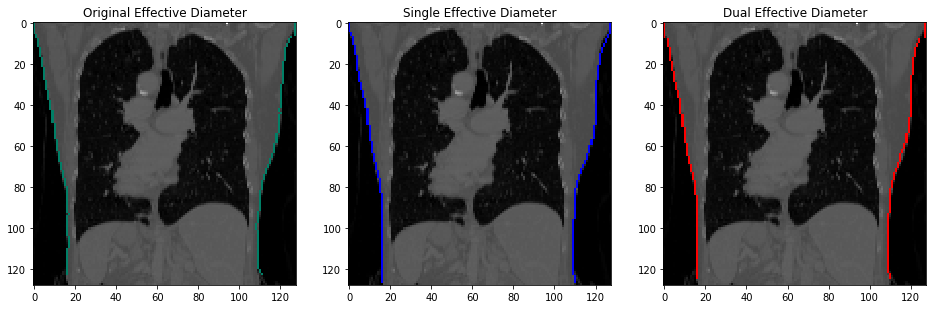

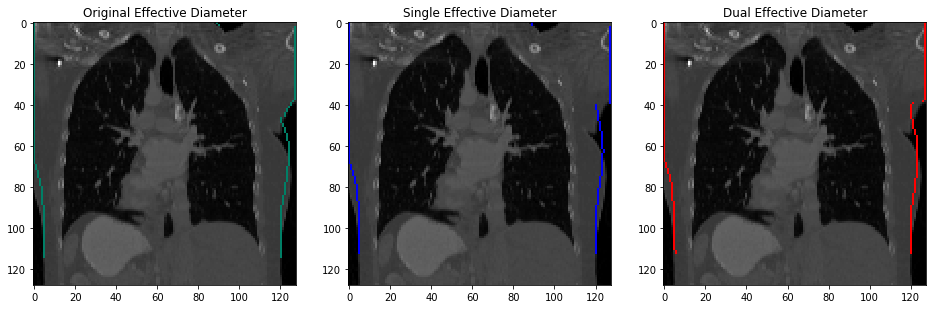

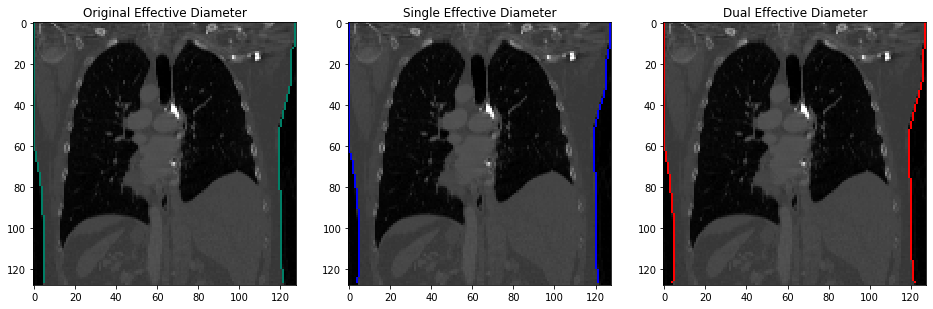

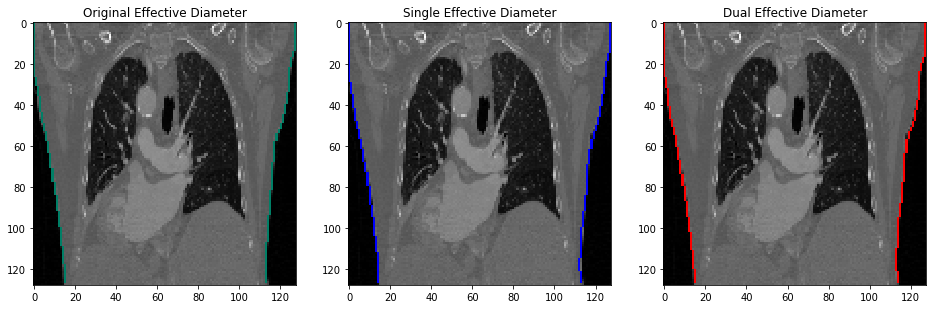

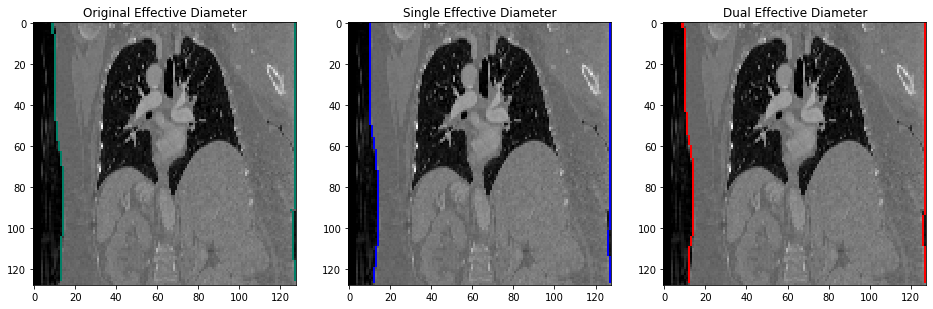

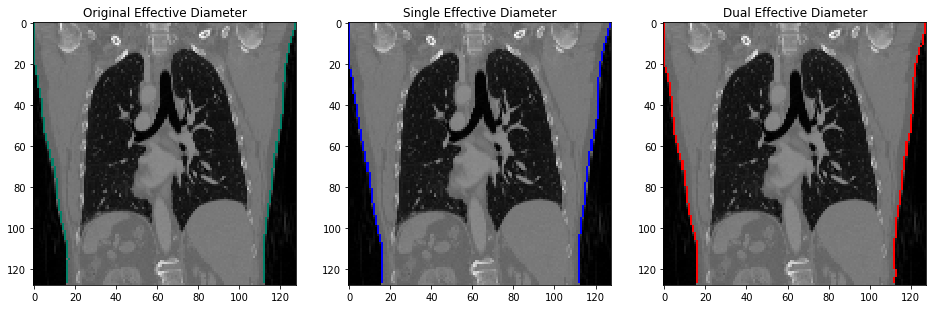

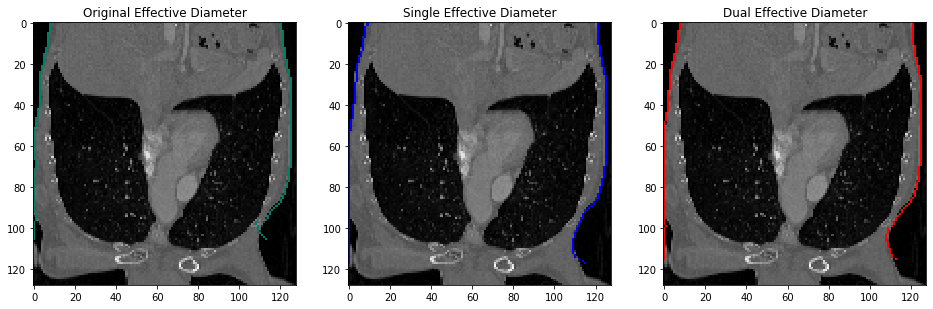

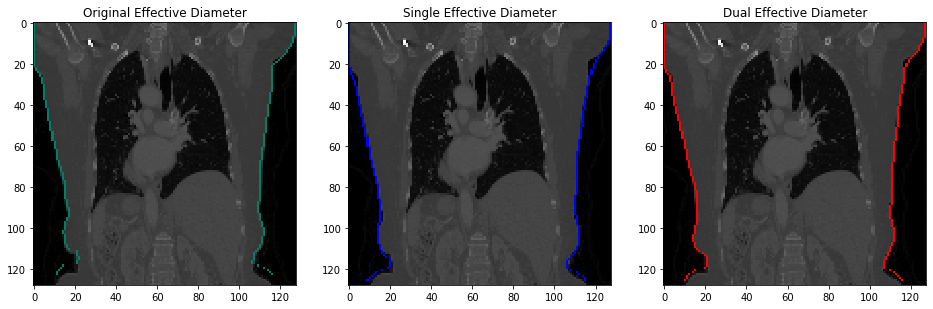

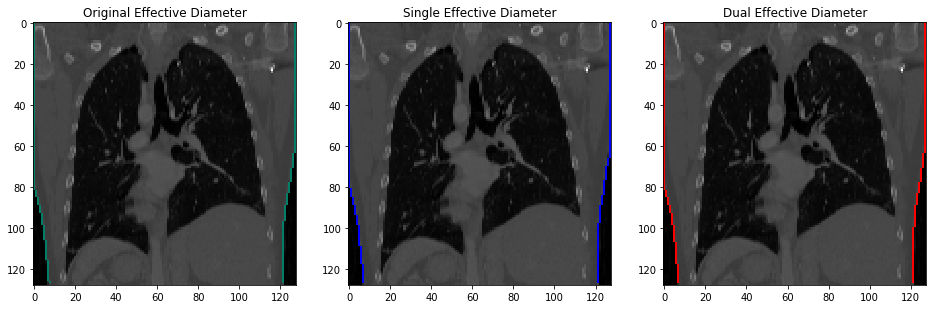

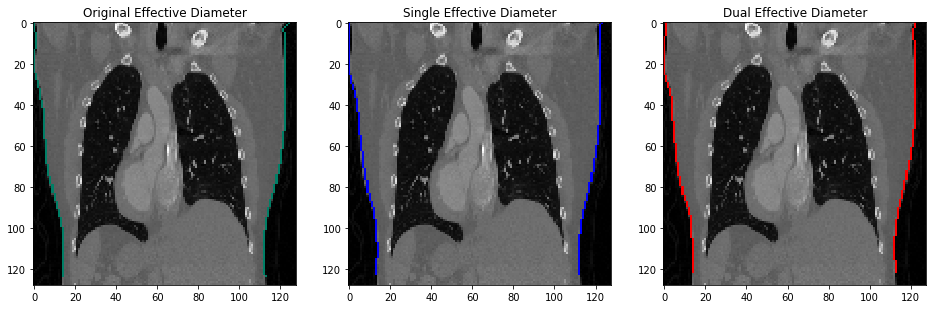

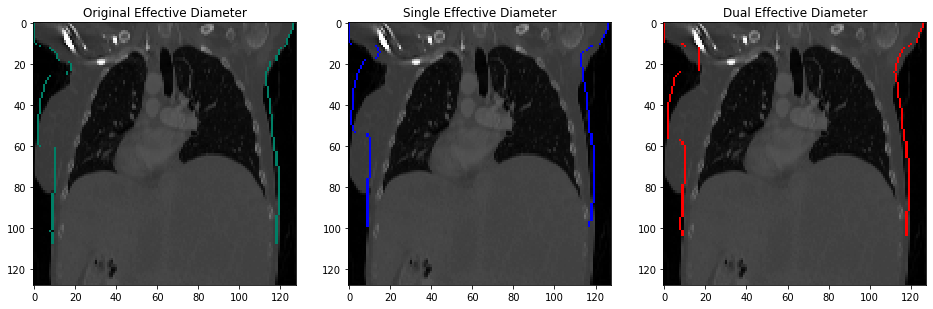

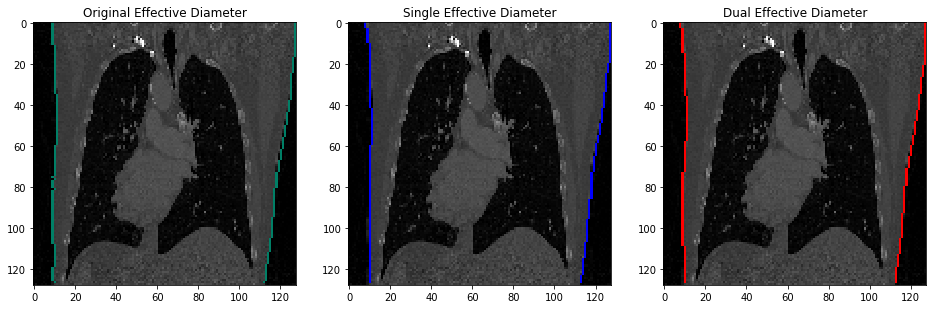

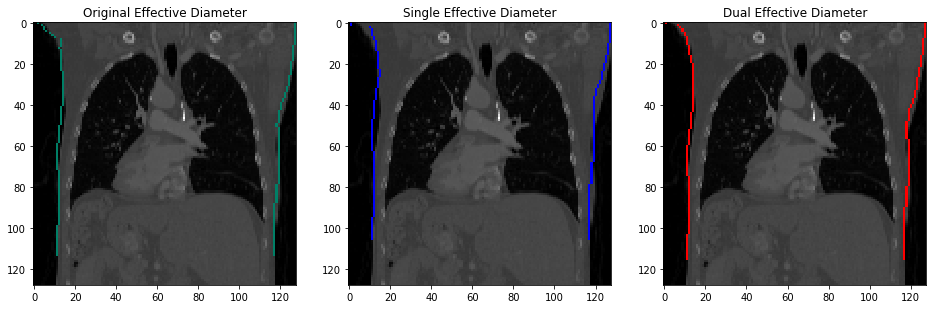

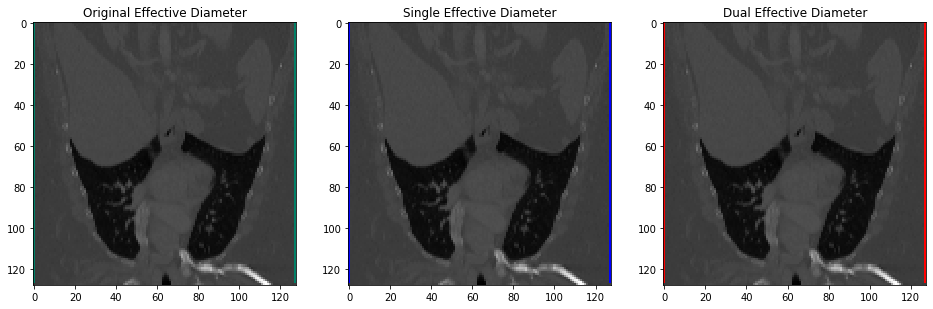

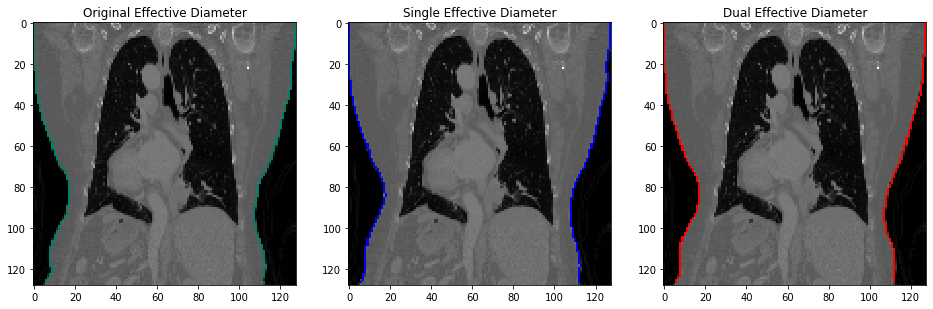

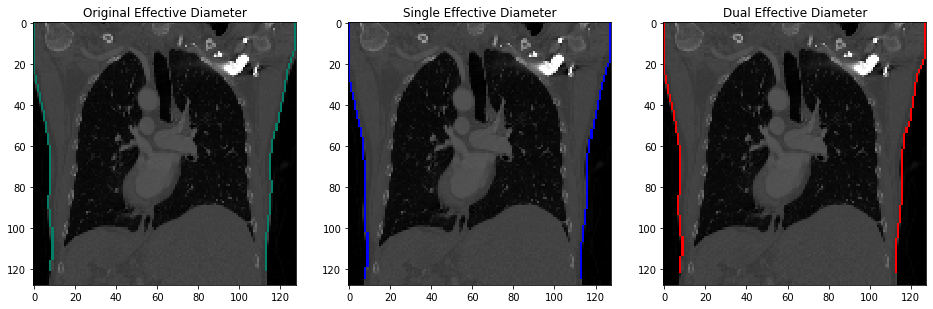

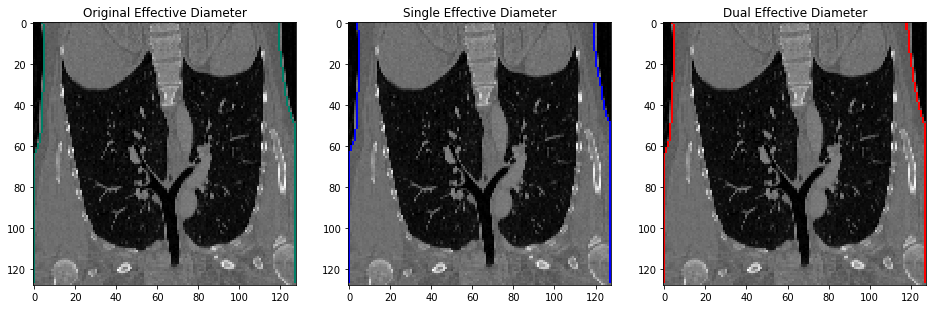

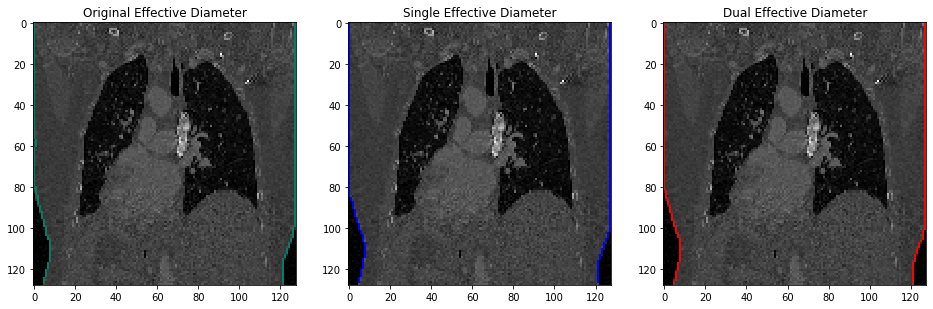

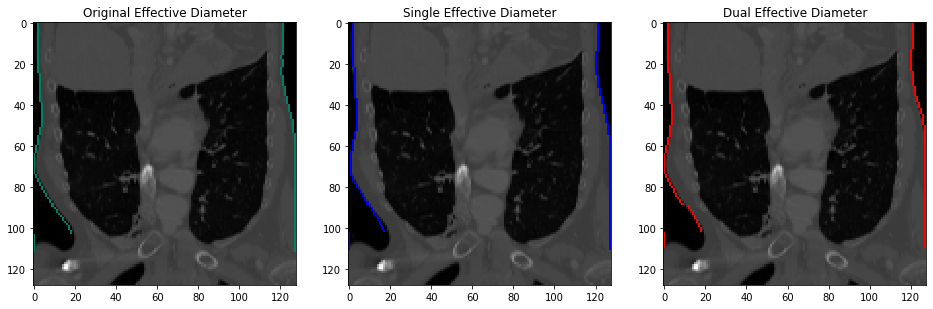

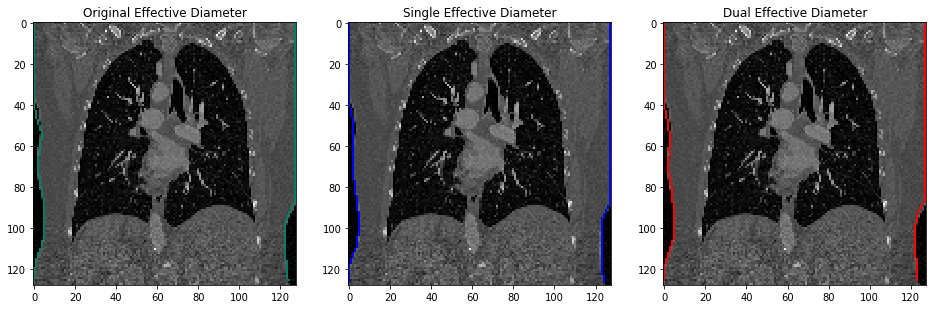

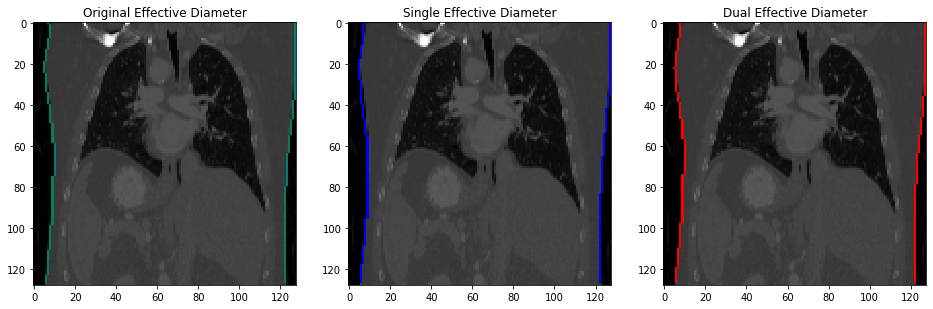

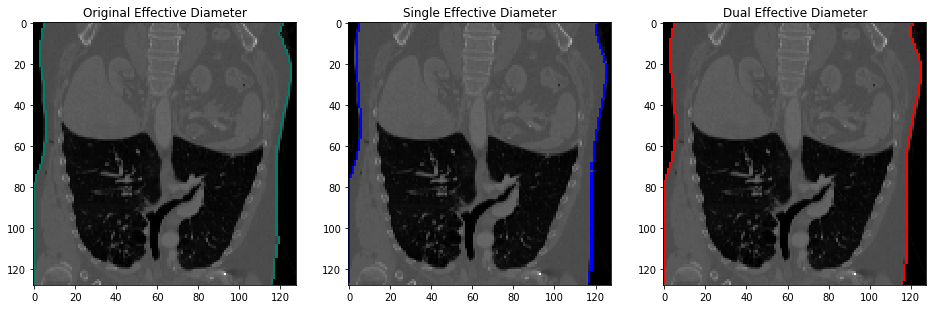

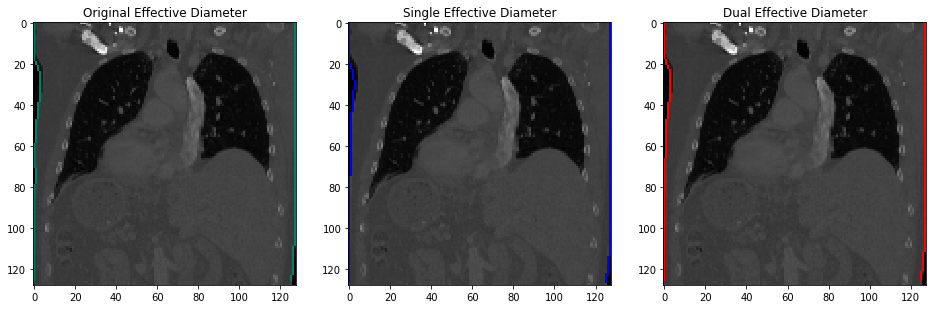

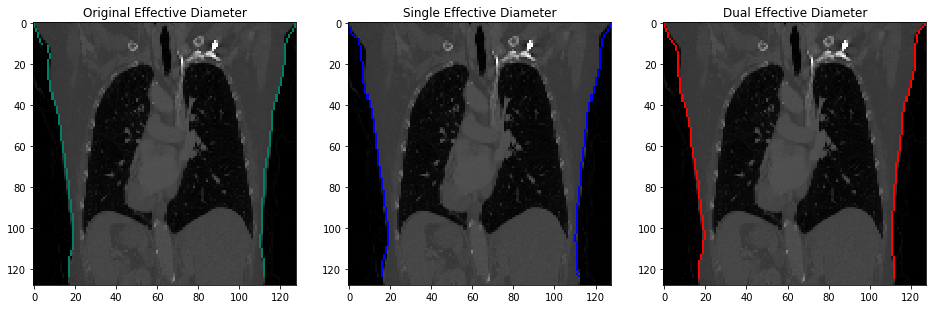

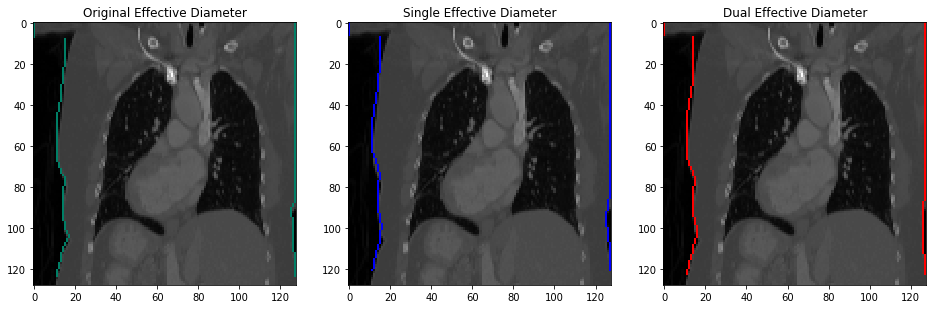

In [10]:
def wed_plot_transverse_triple(index):
    
    input_1 = pd.x_train_0[index]
    input_2 = pd.x_train_1[index]
    
    input_1 = np.reshape(input_1, (1, 1024, 1024, 1))
    input_2 = np.reshape(input_2, (1, 1024, 1024, 1))
    
    output_single = single_model.predict(input_1)
    output_double = double_model.predict([input_1, input_2])
    
    output_single = np.reshape(output_single, (128, 128, 128))
    output_double = np.reshape(output_double, (128, 128, 128))
    
    original = pd.y_train[index]
    
    org_copy = deepcopy(original)
    single_copy = deepcopy(output_single)
    double_copy = deepcopy(output_double)
    
    contour_org = contour_image(org_copy)
    contour_single = contour_image(single_copy)
    contour_double = contour_image(double_copy)
    
    bl_org = get_blank_array(contour_org)
    bl_single = get_blank_array(contour_single)
    bl_double = get_blank_array(contour_double)
    
    f = plt.figure(figsize = (16, 6))
    
    f.add_subplot(1, 3, 1)
    plt.imshow(pd.y_train[index][:, 64], cmap = 'gray')
    plt.imshow(ma.masked_values(bl_org, 0), cmap = 'summer')
    plt.title("Original Effective Diameter")
    
    f.add_subplot(1, 3, 2)
    plt.imshow(pd.y_train[index][:, 64], cmap = 'gray')
    plt.imshow(ma.masked_values(bl_single, 0), cmap = 'winter')
    plt.title("Single Effective Diameter")
    
    f.add_subplot(1, 3, 3)
    plt.imshow(pd.y_train[index][:, 64], cmap = 'gray')
    plt.imshow(ma.masked_values(bl_double, 0), cmap = 'autumn')
    plt.title("Dual Effective Diameter")
    plt.show()
    
for i in range(0, 128):
    
    wed_plot_transverse_triple(i)